**Part 1: Model Inpainting**

**Summary**

This notebook allows for the image curation, model optimization, and statistical benchmarking associated with radiograph inpainting. Each section can be mounted seperately based upon resource requirements (gpu vs cpu). The main folder used to read/write study related files is Part1.

Within the results folder, the two relevant sweep files (hyper-parameter optimization & testing) are:
1. Hyper-parameter Optimization: /content/gdrive/MyDrive/DL_Assignment/Part1/results/2d-unet-sweep-2023-06-11-00-53-06/
2. Testing: /content/gdrive/MyDrive/DL_Assignment/Part1/results/2d-unet-test-2023-06-12-18-18-59/



# Preprocessing


In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#installations
!pip install --quiet SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 18.9 MB/s eta 0:00:00


In [ ]:
#imports
import pandas as pd
import os
import glob
import SimpleITK as sitk
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection

In [ ]:
#functions

#used for finding the ID
def find_between(s, start, end):
    return (s.split(start))[1].split(end)[0]

#prepare the data
def prepare_data(row, folder_path):
  #update the folder path
  data_path = folder_path + row['Rad_Name']
  #get the ID
  id = int(find_between(row['Rad_Name'], 'unlabeled_image', '.png'))
  #return
  return data_path, id

#resampling function for medical images
def resample_image_standardize(itk_image, out_size = (64, 64)):
  #get the original spacing
  original_spacing = itk_image.GetSpacing()
  #get the size
  original_size = itk_image.GetSize()
  #get the new spacing
  out_spacing = [original_size[0] * (original_spacing[0] / out_size[0]),
                 original_size[1] * (original_spacing[1] / out_size[1])
                 ]
  #resampling
  resample = sitk.ResampleImageFilter()
  resample.SetOutputSpacing(out_spacing)
  resample.SetOutputOrigin(itk_image.GetOrigin())
  resample.SetSize(out_size)
  resample.SetOutputDirection(itk_image.GetDirection())
  resample.SetTransform(sitk.Transform())
  #label
  resample.SetInterpolator(sitk.sitkBSpline)
  #return
  return resample.Execute(itk_image)

#seperate into independent folds
def get_folds(df, n_splits):
  #the splitter
  skf = sklearn.model_selection.KFold(n_splits = n_splits, shuffle = False)
  #init
  df_ls = []
  #iterate
  for i, (_, fold_index) in enumerate(skf.split(df)):
    #set
    df_fold = df.loc[fold_index,:]
    #insert
    df_fold['Fold'] = i + 1
    #append
    df_ls.append(df_fold)
  #return
  return pd.concat(df_ls).reset_index(drop = True)

#save image
def save_image(save_path, save_folder, patient, image):
  #save file
  if os.path.isdir(save_path + save_folder) == False:
    os.mkdir(save_path + save_folder)
  #save file
  save_loc = save_path + save_folder + '/' + patient + '.nii.gz'
  #write
  sitk.WriteImage(image, save_loc)
  #return
  return save_loc

#prepare the model input data
def prepare_inputs(row, save_path, save_folder, norm):
  #read the image data
  image = sitk.ReadImage(row['Rad'])
  #normalize
  image = minmax(image)
  #return
  return save_image(save_path, save_folder, row['Rad_Name'].replace('.png',''), image)

#minmax
def minmax(image):
  arr = sitk.GetArrayFromImage(image).astype('float32')
  arr = (arr - arr.min())/(arr.max() - arr.min())
  new_image = sitk.GetImageFromArray(arr)
  new_image.CopyInformation(image)
  return new_image

#get the normalization filter
def norm_filter(norm_type = 'minmax'):
  #minmax
  if norm_type == 'minmax':
    norm = sitk.IntensityWindowingImageFilter()
    norm.SetOutputMaximum(1)
    norm.SetOutputMinimum(0)
  #z-norm
  if norm_type == 'z':
    norm = sitk.NormalizeImageFilter()
  #return
  return norm

#obtain train test split
def dataset(df, folds, test_split):
  #split
  df_train, df_test = sklearn.model_selection.train_test_split(df, test_size = test_split, random_state = 42, shuffle = True)
  #get folds for train set
  df_train = get_folds(df_train.reset_index(drop = True), folds)
  #label the test set
  df_test['Fold'] = 'Test'
  #concat
  return pd.concat([df_train, df_test]).reset_index(drop = True)

In [ ]:
#init

#read in the unlabeled data
data_path1 = '/content/gdrive/MyDrive/DL_Assignment/Unlabeled/'
#specify the number of folds
folds = 5
#test split
test_split = 0.2
#preprocessing save locations
save_folder = 'Norm-Rad'
save_path = '/content/gdrive/MyDrive/DL_Assignment/Part1/'

In [ ]:
%%time
#main

#read in the unlabeled data
df = pd.DataFrame(sorted(os.listdir(data_path1)), columns = ['Rad_Name'])
#prepare the data
df['Rad'], df['ID'] = zip(*df.apply(prepare_data, axis = 1, args = (data_path1, )))
#specify the fold sets
df = dataset(df, folds, test_split)
#view the dataset splits
print(df['Fold'].value_counts())
#get norm
norm = norm_filter('minmax')
#prepare the model inputs
df[save_folder] = df.apply(prepare_inputs, axis = 1, args = (save_path, save_folder, norm))
#save the df
df.to_pickle(save_path + save_folder + '/' + 'df_inputs.pkl')

Test    1487
1       1190
2       1190
3       1189
4       1189
5       1189
Name: Fold, dtype: int64
CPU times: user 2min 1s, sys: 21 s, total: 2min 22s
Wall time: 8min 51s


**Introduction**
1. The filepaths to the unlabeled radiographs was established.
2. The dataset was split into training set and testing set.
3. The training set consisted of 5 independent folds, the counts are listed in the script.
4. Each 2D radiograph was min-max normalized (values fit between 0-1) and saved to serve as model inputs.

**Justification**

1. Storing information on each patient-specific file in a tabular format is essential for organizing complex deep learning experiments.
2. Row-wise represents each patient and column-wise describes the patient's file.
3. A sufficient amount of testing data was taken (20% of the overall set) to determine performance for out-of-sample results.

**Conclusion**

1. The data has been stored in a machine-learning ready format.
2. While there are 5 independent folds in the training set, only 1 fold will be used for validation while the remaining 4 folds will be used for training (for brevity).

# Training

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#installations
!pip install --quiet SimpleITK
!pip install --quiet livelossplot
!pip install --quiet wandb
!pip install --quiet segmentation-models-pytorch
#!pip install --quiet inplace-abn
!pip install --quiet torchgeometry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 24.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 2.9 MB/s eta 0:0

In [ ]:
#imports
import os
import torch
import wandb
import pandas as pd
import sys
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import SimpleITK as sitk
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
import torchvision
import livelossplot
from livelossplot import PlotLosses
import scipy
import datetime
from datetime import datetime
import torchgeometry as tgm
import segmentation_models_pytorch as smp
import json
#check if the gpu machine is available
if torch.cuda.is_available():
  device = 'cuda'
  gpu = torch.cuda.get_device_name(0)
  print('Device: ', gpu)
else:
  device = 'cpu'
  gpu = None
  print('Device', device)

#wanddb
key = "0ededc30a9b327450989bd6593cec2dbb642fc7a" #specify wandb key
#Weights and Bias
if key:
  wandb.login(key=key) #API Key is in your wandb account, under settings (wandb.ai/settings)

Device:  Tesla T4


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#functions

#Dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, col_image, input_size, aug = False):
      #params
      self.df = df
      self.aug = aug
      self.col_image = col_image
      self.input_size = input_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      #row
      row = self.df.iloc[idx]
      #read image
      image = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(sitk.ReadImage(row[self.col_image])), axis = 0))

      #if aug
      if self.aug:
        #augmentation (increase this given size of the data)
        if random.random() > 0.5:
          #horizontal
          image = torchvision.transforms.functional.hflip(image)
        if random.random() > 0.5:
          #vertical
          image = torchvision.transforms.functional.vflip(image)
        #rotate
        if random.random() > 0.5:
          #rotate
          #image = torchvision.transforms.functional.rotate(image, random.choice([90, 180, 270]))
          image = torchvision.transforms.functional.rotate(image, random.choice([30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]))
        #invert color scale
        if random.random() > 0.5:
          image = torchvision.transforms.functional.invert(image)
        #noise
        #if random.random() > 0.5:
          #noise = torch.normal(random.uniform(-0.5, 0.5), random.uniform(0.01, 0.05), image.shape)
          #image = image + noise
      #init
      mask = torch.ones((1, self.input_size[0], self.input_size[1]))
      #random x
      x = random.randint(0, self.input_size[0]/2)
      #get random y
      y = random.randint(0, self.input_size[1]/2)
      #get random delta x
      xd = random.randint(self.input_size[0]/4, self.input_size[0]/2)
      #get random delta y
      yd = random.randint(self.input_size[1]/4, self.input_size[1]/2)
      #set the mask
      mask[:, x:x+xd, y:y+yd] = 0
      #apply
      cut_image = image * mask
      #return x_input, x_true
      return cut_image, image

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#get the optimizer
def get_optimizer(model_config, model):
  #AdamW
  if model_config['optimizer'] == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr = model_config['init_lr'], weight_decay = model_config['weight_decay'])
  #return
  return optimizer

#model saving policy
def save_model(model_config, model):
  #save model use weights instead
  model.eval()
  #depending on choice
  if model_config['save_weights_only']:
    torch.save(model.state_dict(), model_config['save_folder'] + 'model_weights.pth')
  else:
    torch.save(model, model_config['save_folder'] + 'model.pth')
  #save info
  save_params(model_config, model_config['save_folder'] + 'model_config.json')

#update previously saved config only
def update_config_stopearly(save_path):
  #load
  model_config = load_params(save_path + 'model_config.json')
  #update
  model_config['early_stopping']['stopped_early'] = True
  #save
  save_params(model_config, save_path + 'model_config.json')

#new saving policy
def new_saving_policy(early_stop, best_model, model_config, model, epoch):
  #if there is an early stop
  if early_stop:
    #exit training
    exit_training = True
    #has the model been already saved?
    if model_config['early_stopping']['model_criteria']:
      #save just the config with update
      update_config_stopearly(model_config['save_folder'])
    #if not already saved
    else:
      #update
      model_config['early_stopping']['stopped_early'] = True
      #save the model and config
      save_model(model_config, model)
  #if there is not early stop
  else:
    #exit
    exit_training = False
    #need to log that we did not exit training early
    model_config['early_stopping']['stopped_early'] = False
    #you want to save the model every n_epochs often
    if model_config['save_best_model'] == False:
      #check if epocch is divisible and nonzero
      if (epoch % model_config['save_after_n_epochs'] == 0) and (epoch != 0):
        #indicate the model was saved
        model_config['early_stopping']['model_criteria'] = True
        #save
        save_model(model_config, model)
    else:
      #you want to save the best model
      if model_config['epochs_trained'] >= model_config['save_after_n_epochs']:
        #check if current model is the best model
        if best_model:
          #log that it is the best model
          model_config['early_stopping']['best_model'] = True
          #indicate the model was saved
          model_config['early_stopping']['model_criteria'] = True
          #then save
          save_model(model_config, model)
        #if current model is not the best model but want to save for the initital run
        if (best_model == False) and (model_config['epochs_trained'] == model_config['save_after_n_epochs']):
          #inidicate the model was saved
          model_config['early_stopping']['model_criteria'] = True
          #save the model and config
          save_model(model_config, model)

  #return
  return model_config, exit_training

#class earlystopping
class EarlyStopping:
  #early stop if validation does not improve for given patience
  def __init__(self, model_config, verbose = True, trace_func = print):
    #set up
    self.patience = model_config['early_stopping']['patience']
    self.delta = model_config['early_stopping']['delta']
    self.verbose = verbose
    self.trace_func = trace_func
    self.counter = 0
    self.best_score = None
    self.best_model = False
    self.early_stop = False

  #call
  def __call__(self, val_loss):
    #neg val loss
    score = -val_loss
    #init condition
    if self.best_score is None:
      self.best_score = score
    #count number of times model failed to meet the condition
    elif score < self.best_score + self.delta:
      self.counter += 1
      self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      self.best_model = False
      #identify when early stopping is required
      if self.counter >= self.patience:
        self.early_stop = True
    #if the model shows best score
    else:
      #get the score and counter
      self.best_score = score
      self.counter = 0
      self.best_model = True
    #return the interl
    return self.early_stop, self.best_model

#get the loss fn
def get_loss(model_config, device = None):
  #mse pytorch
  if model_config['loss']['description'] == 'pytorch_mse':
    criterion = torch.nn.MSELoss()

  #ssim torchgeo
  if model_config['loss']['description'] == 'geo_ssim':
    criterion = tgm.losses.SSIM(window_size = model_config['loss']['window_size'], reduction = 'mean')

  #custom style and perception loss
  if model_config['loss']['description'] == 'custom_styleper':
    criterion = StylePerLoss(model_config, device)

  #return
  return criterion

#get scheduler
def get_scheduler(model_config, optimizer):
  #plateau
  if model_config['scheduler']['description'] == 'plateau':
    #get the scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = model_config['scheduler']['mode'],
                                                           factor = model_config['scheduler']['factor'],
                                                           patience = model_config['scheduler']['patience'],
                                                           threshold = model_config['scheduler']['threshold'],
                                                           threshold_mode = model_config['scheduler']['threshold_mode'],
                                                           cooldown = model_config['scheduler']['cooldown'],
                                                           min_lr = model_config['scheduler']['min_lr'],
                                                           eps = model_config['scheduler']['eps'],
                                                           verbose = True)
  #return
  return scheduler

#get the model
def get_model(model_config):
  #get the model for smp unet
  if model_config['architecture']['description'] == 'smp_unet':
    #https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/base/model.py
    model = smp.Unet(encoder_name = model_config['architecture']['encoder_name'],
                     encoder_depth = model_config['architecture']['encoder_depth'],
                     encoder_weights = model_config['architecture']['encoder_weights'] ,
                     decoder_use_batchnorm = model_config['architecture']['decoder_use_batchnorm'],
                     decoder_channels = model_config['architecture']['decoder_channels'],
                     decoder_attention_type = model_config['architecture']['decoder_attention_type'],
                     in_channels = model_config['architecture']['in_channels'],
                     classes = model_config['architecture']['classes'],
                     activation = model_config['architecture']['activation'],
                     aux_params = None)

  #return
  return model

#load pretrained model
def load_pretrained_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_model(model_config)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config

#adding style and perception losses
class StylePerLoss(torch.nn.Module):
  #init
  def __init__(self, model_config, device):
    #super
    super(StylePerLoss, self).__init__()
    #model encoder
    self.model_encoder = smp.Unet(in_channels = 1, encoder_weights = 'imagenet',
                                  encoder_name = 'timm-mobilenetv3_small_minimal_100').encoder
    #eval
    self.model_encoder.eval()
    #send
    self.model_encoder.to(device)
    #l
    self.l1 = model_config['loss']['sty_l1']
    self.l2 = model_config['loss']['per_l2']
    self.l3 = model_config['loss']['rec_l3']
    #recon loss
    self.recon_loss = tgm.losses.SSIM(window_size = model_config['loss']['window_size'], reduction = 'mean')
  #gram
  def gram(self, x):
    # get the batch size, channels, height, and width of the image
    (bs, ch, h, w) = x.size()
    f = x.view(bs, ch, w * h)
    G = f.bmm(f.transpose(1, 2)) / (ch * h * w)
    return G
  #style loss
  def calc_style_loss(self, gen, style):
    #gram matrix
    G = self.gram(gen)
    A = self.gram(style)
    return torch.nn.functional.l1_loss(G, A)
    #return torch.mean((G-A)**2)
  #perception loss
  def calc_perception_loss(self, gen_feat, orig_feat):
    return torch.nn.functional.l1_loss(gen_feat, orig_feat)
    #return torch.mean((gen_feat-orig_feat)**2)
  #forward
  def forward(self, x_pred, x_true):
    #init
    style_loss = 0.0
    per_loss = 0.0
    rec_loss = 0.0
    #apply
    with torch.no_grad():
      #first map is the original input
      x_pred_features = self.model_encoder(x_pred)[1:]
      x_true_features = self.model_encoder(x_true)[1:]
    #iterate
    for i, (x_pred_feature, x_true_feature) in enumerate(zip(x_pred_features, x_true_features)):
      #style loss
      style_loss += self.calc_style_loss(x_pred_feature, x_true_feature)
      #perception loss
      per_loss += self.calc_perception_loss(x_pred_feature, x_true_feature)
    #recon loss
    rec_loss = self.recon_loss(x_pred, x_true)
    #return
    return self.l1 * style_loss + self.l2 * per_loss + self.l3 * rec_loss

In [ ]:
#main script
def main(config = None):
  #clear workspace when finished with a single model run
  model, x_true, x_pred, loss = (None, None, None, None)
  dset_train, train_loader, dset_val, val_loader = (None, None, None, None)
  criterion, optimizer, scheduler, early_stopper = (None, None, None, None)
  #reset
  if device == 'cuda':
    torch.cuda.empty_cache()

  #name the model
  model_name = datetime.now().strftime('2d-unet-painting-%Y-%m-%d-%H-%M-%S')

  #init a new wandb run (config = sweep_config)
  with wandb.init(config = config, name = model_name):
    #set up the config (WandB, locked)
    config = wandb.config
    #dict (not locked)
    model_config = dict(config)
    #name the model
    model_config['model'] = model_name
    #save location
    model_config['save_folder'] = model_config['save_folder'] +  model_config['model'] + '/'
    #create the model folder
    if os.path.isdir(model_config['save_folder']) == False:
      os.mkdir(model_config['save_folder'])

    #training data(not in valkfolds!)
    df_train = df[(~df['Fold'].isin(model_config['val_kfolds'])) & (df['Fold'] != 'Test')]
    #val data (in valkfolds)
    df_val = df[(df['Fold'].isin(model_config['val_kfolds'])) & (df['Fold'] != 'Test')]

    #save some info on the parameters in the training and validation sets of this script
    df_train['Split'] = 'TRAIN'
    df_val['Split'] = 'VAL'
    #test
    df_test = df[df['Fold'] == 'Test']
    df_test['Split'] = 'TEST'
    #save
    df_train_val = pd.concat([df_train, df_val, df_test])
    #can use sort index to preserve order in preprocessing as well
    df_train_val.sort_index(inplace = True)
    df_train_val.to_pickle(model_config['save_folder'] + 'df_results.pkl')

    #get the training data (remove the folds corresponding to validation)
    dset_train = CustomImageDataset(df_train,
                                    col_image = model_config['col_image'], input_size = model_config['input_size'],
                                    aug = model_config['aug'])
    #train loader
    train_loader = DataLoader(dset_train, batch_size = model_config['batch_size'])

    #get the validation data
    dset_val = CustomImageDataset(df_val,
                                  col_image = model_config['col_image'], input_size = model_config['input_size'],
                                  aug = False)
    #val loader
    val_loader = DataLoader(dset_val, batch_size = model_config['batch_size'])

    #init the model
    model = get_model(model_config)
    #send
    model.to(device)
    #criterion (can get loss based on training data)
    criterion = get_loss(model_config, device)
    #optimizer
    optimizer = get_optimizer(model_config, model)
    #scheduler
    scheduler = get_scheduler(model_config, optimizer)
    #early stopping (save time during the sweep)
    early_stopper = EarlyStopping(model_config)

    #track in Jupter Notebook
    liveloss = PlotLosses()
    #logs
    logs = {}

    #track for later
    log_train_loss = []
    log_train_acc = []
    log_val_loss = []
    log_val_acc = []

    #iterate through the entire dataset
    #+1 for shifting (python starts at 0)
    for epoch in range(model_config['epochs_trained'] + 1, model_config['epochs'] + 1):
      #determine train losses
      train_epoch_loss = 0
      #set for training
      model.train()
      #iterate through the training data
      for i, (x_input, x_true) in enumerate(train_loader):
        #zero optimizer
        optimizer.zero_grad()
        #predict
        x_pred = model(x_input.to(device))
        #determine loss (should already be averaged)
        loss = criterion(x_pred, x_true.to(device))
        #backward
        loss.backward()
        #step
        optimizer.step()
        #track the loss
        train_epoch_loss = train_epoch_loss + loss.item()
        #reset
        print('Training ', loss.item())
        x_input, x_true, x_pred, loss = (None, None, None, None)
        if device == 'cuda':
          torch.cuda.empty_cache()
      #calculate train loss
      train_loss = train_epoch_loss / len(train_loader)
      #calculate train acc
      train_acc = 1 - train_loss

      #determine validation losses
      val_epoch_loss = 0
      #specify eval
      model.eval()
      #set
      with torch.no_grad():
        #iterate
        for i, (x_input, x_true) in enumerate(val_loader):
          #predict
          x_pred = model(x_input.to(device))
          #determine loss
          loss = criterion(x_pred, x_true.to(device))
          #track the loss (shoudld already be averaged)
          val_epoch_loss = val_epoch_loss + loss.item()
          #reset
          print('Validation ', loss.item())
          x_input, x_true, x_pred, loss = (None, None, None, None)
          if device == 'cuda':
            torch.cuda.empty_cache()
      #calulate val loss
      val_loss = val_epoch_loss / len(val_loader)
      #calulate val acc
      val_acc = 1 - val_loss

      #scheduler
      scheduler.step(train_loss)

      #record for training
      log_train_loss.append(train_loss)
      log_train_acc.append(train_acc)
      #record for validation
      log_val_loss.append(val_loss)
      log_val_acc.append(val_acc)

      #wont log lossess or acc after early stopping or save best model

      #log the most recent info
      model_config['train_loss'] = train_loss
      model_config['train_acc'] = train_acc
      model_config['val_loss'] = val_loss
      model_config['val_acc'] = val_acc

      #log all the info
      model_config['log_train_loss'] = log_train_loss
      model_config['log_train_acc'] = log_train_acc
      model_config['log_val_loss'] = log_val_loss
      model_config['log_val_acc'] = log_val_acc

      #keep track of each epoch
      model_config['epochs_trained'] = epoch

      #print
      print('Epoch {0} of {1}: Train Loss {2:.2g} & Acc {3:.2g} v Val Loss {4:.2g} and Acc {5:.2g}'.format(epoch, model_config['epochs'],
                                                                                                           train_loss, train_acc, val_loss, val_acc))

      #wandb
      wandb.log(model_config)


      #determine if early stopping is required by validation loss
      early_stop, best_model = early_stopper(train_loss)
      #saving policy and determine if training should be exited based on early stop and best model
      model_config, exit_training = new_saving_policy(early_stop, best_model, model_config, model, epoch)

      #specify the logs
      prefix = ''
      logs['Loss'] = train_loss
      logs['Acc'] = train_acc
      #logs
      prefix = 'val_'
      logs[prefix + 'Loss'] = val_loss
      logs[prefix + 'Acc'] = val_acc

      #living loss
      liveloss.update(logs)
      #send
      liveloss.send()

      #exit training early
      if exit_training:
        print('Early Stop: Exit Training')
        break

    #clear workspace when finished with a single model run
    model, x_input, x_true, x_pred, loss = (None, None, None, None, None)
    dset_train, train_loader, dset_val, val_loader = (None, None, None, None)
    criterion, optimizer, scheduler, early_stopper = (None, None, None, None)
    #reset
    if device == 'cuda':
      torch.cuda.empty_cache()

In [ ]:
#parameters in wandb format
sweep_config = {
    #name decided later (sweep name)
    'name': None,
    #sweep method
    'method': 'grid',
    #metric
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize',
    },
    #values which may be altered wandb wants all components
    'parameters': {
        #description
        'description': {'value': 'Model which paints the missing radiograph patch'},
        #project in wandb
        'project':{'value': 'OSAIL Part 1'},
        'model': {'value': None}, #placeholder for actual name
        #documentation
        'data_path': {'value': '/content/gdrive/MyDrive/DL_Assignment/Part1/Norm-Rad/df_inputs.pkl'}, #the input csv with filepaths
        #path to save the results of the sweep
        'save_folder': {'value': '/content/gdrive/MyDrive/DL_Assignment/Part1/results/'},
        'col_image': {'value': 'Norm-Rad'}, #input column of the csv
        'device': {'value': device},
        'val_kfolds': {'values': [[5]]}, #kfolds for validation // can specify more than one fold in a validation set
        #specify the image input size
        'input_size': {'values': [(224, 224, 224)]},
        #model architecture
        'architecture': {'values': [
            {'description': 'smp_unet',
             'encoder_name': 'timm-mobilenetv3_small_minimal_100', #smallest architecture
             'encoder_depth': 5,
             'encoder_weights': None,
             'decoder_use_batchnorm': True,
             'decoder_channels': (256, 128, 64, 32, 16),
             'decoder_attention_type': None,
             'in_channels': 1,
             'classes': 1,
             'activation': 'sigmoid',
             'aux_params': None
             }
        ]},
        #training params
        'aug': {'values': [True]},
        'batch_size': {'values': [100]},
        'init_lr': {'values': [5e-4]},
        'epochs': {'values': [30]}, #max epochs to train
        'epochs_trained': {'value': 0}, #this is updated in the script!
        'save_after_n_epochs': {'value': 5}, #depends on if you want to save the best model
        'weight_decay': {'values': [1e-6]},
        'optimizer': {'values': ['AdamW']},
        'scheduler': {'values': [
            {'description': 'plateau',
             'mode': 'min',
             'factor': 5e-1,
             'patience': 2, #2
             'threshold': 1e-2, #1e-2
             'threshold_mode': 'rel',
             'cooldown': 0,
             'min_lr': 0,
             'eps': 1}]},
        'loss': {'values': [
            {'description': 'geo_ssim', 'window_size': 55}, #ssim window size 55
            {'description': 'custom_styleper', 'sty_l1': 1, 'per_l2': 0.1, 'rec_l3': 1, 'window_size': 55}, #l1: 1, 0.1, 1; mse: 10, 0.01,  l1 loss + ssim
            {'description': 'pytorch_mse'}, #mse
            ]},
        #saving
        'save_weights_only': {'value': True},
        'save_best_model': {'value': True},
        #early stopping
        'early_stopping': {'value':
            {'patience': 5,
            'delta': 1e-2, #1e-2 or 5e-3
            'stopped_early': None, #indicate if stopped early
            'best_model': None, #indicate if best model (if save best model)
            'model_criteria': False}
        },
        #log the model loss and acc
        'log_train_loss': {'value': None},
        'log_train_acc': {'value': None},
        'log_val_loss': {'value': None},
        'log_val_acc': {'value': None},
        #updating performance in WandB
        'train_loss': {'value': None},
        'train_acc': {'value': None},
        'val_loss': {'value': None},
        'val_acc': {'value': None}
    }
}


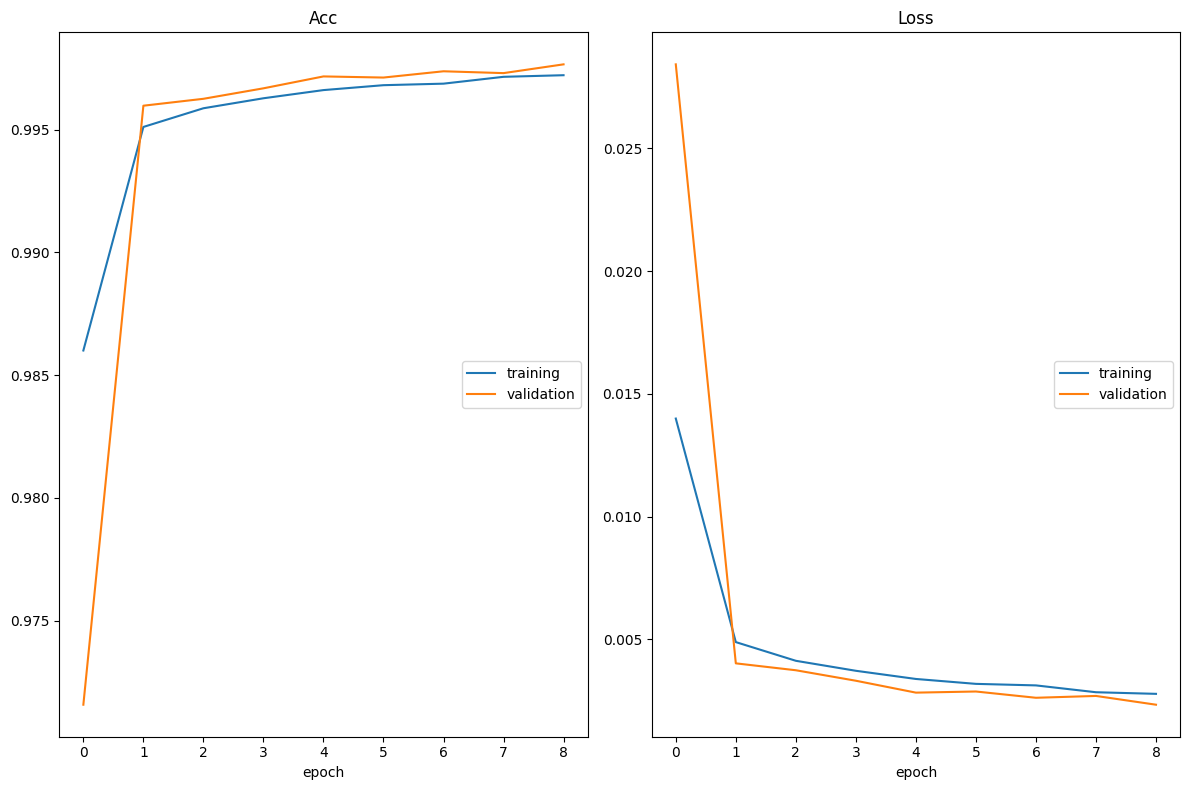

Acc
	training         	 (min:    0.986, max:    0.997, cur:    0.997)
	validation       	 (min:    0.972, max:    0.998, cur:    0.998)
Loss
	training         	 (min:    0.003, max:    0.014, cur:    0.003)
	validation       	 (min:    0.002, max:    0.028, cur:    0.002)
Early Stop: Exit Training


aug,▁▁▁▁▁▁▁▁▁
batch_size,▁▁▁▁▁▁▁▁▁
epochs,▁▁▁▁▁▁▁▁▁
epochs_trained,▁▂▃▄▅▅▆▇█
init_lr,▁▁▁▁▁▁▁▁▁
save_after_n_epochs,▁▁▁▁▁▁▁▁▁
save_best_model,▁▁▁▁▁▁▁▁▁
save_weights_only,▁▁▁▁▁▁▁▁▁
train_acc,▁▇▇▇█████
train_loss,█▂▂▂▁▁▁▁▁
val_acc,▁████████


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


CPU times: user 1h 33min 10s, sys: 15min 29s, total: 1h 48min 39s
Wall time: 4h 13min 11s


In [ ]:
%%time
#main script

#set the random seed
#random.seed(42)

if __name__ == '__main__':

  #read the pickle file
  df = pd.read_pickle(sweep_config['parameters']['data_path']['value'])

  #specify the sweep save location
  sweep_config['name'] = datetime.now().strftime('2d-unet-sweep-%Y-%m-%d-%H-%M-%S')
  #set
  sweep_config['parameters']['save_folder']['value'] = sweep_config['parameters']['save_folder']['value'] + sweep_config['name'] + '/'
  #create the sweep folder
  if os.path.isdir(sweep_config['parameters']['save_folder']['value']) == False:
    os.mkdir(sweep_config['parameters']['save_folder']['value'])
  #save the sweep config in the sweep folder
  save_params(sweep_config, sweep_config['parameters']['save_folder']['value'] + 'sweep_config.json')
  #now run the main script

  #select the project folder
  sweep_id = wandb.sweep(sweep_config, project = sweep_config['parameters']['project']['value'])
  #execute the search
  wandb.agent(sweep_id, main)
  #finish
  wandb.finish()

**Introduction**
1. The script is designed to perform both k-fold cross validation and hyper-parameter optimization while communicating results to a WandB account and storing results locally.
2. The output of this code falls in the Part1/results/folder where the sweep folder, one can find the the model-specific folder with .pkl file listing the exact dataset split by fold, .pth file with model weights, and .json file with the precise hyper-parameters used.
3. The script is the main work-horse and is responsible for reading and augmenting model inputs, collecting auxillary components (loss function, learning rate scheduler, early stopping policy, optimizer, etc), and training the deep learning model (UNet).

**Justification**

1. Once more, attention to detail and reproducibility is put at the forefont by storing model parameters locally and online
2. During preliminary studies, it was observed that the missing piece of the radiograph appeared hazy (difficult to see edges). As such, several different loss functions were explored for optimizing model performance.
3. MSE: the intial mean squared error loss function
4. SSIM: the structural similarity index which searches for how well the pixel densities line up
5. Custom: A combination of style loss, perception loss, and SSIM loss functions. Perception loss is computed by comparing the features of the predicted radiograph vs the ground truth radiograph. The style loss is a variation of the previous but compares each features' gram matrices.

**Conclusion**

1. Hyper-parameter optimization was performed, especially across loss functions, under the belief it was the most influential parameter in developing a well-fit model.
2. It may appear that the validation set is out-performing the training set in the above plots, however, this is due to the image augmentation (the training set has harder cases).
3. Note no k-fold cross validation was performed, despite the training script being set-up to do so (for brevity).

# Inference

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#installations
!pip install --quiet SimpleITK
!pip install --quiet segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.1 MB/s eta 0:00:00


In [ ]:
#imports
import glob
import json
import SimpleITK as sitk
import torch
import numpy as np
import pandas as pd
import glob
import segmentation_models_pytorch as smp
import os
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

#check if the gpu machine is available
if torch.cuda.is_available():
  device = 'cuda'
  gpu = torch.cuda.get_device_name(0)
  print('Device: ', gpu)
else:
  device = 'cpu'
  gpu = None
  print('Device', device)

Device:  Tesla T4


In [ ]:
#functions

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#split
def split_given_size(a, size):
  return np.split(a, np.arange(size, len(a), size))

#save image
def save_image(save_path, save_folder, patient, image):
  #save file
  if os.path.isdir(save_path + save_folder) == False:
    os.mkdir(save_path + save_folder)
  #save file
  save_loc = save_path + save_folder + '/' + patient + '.nii.gz'
  #write
  sitk.WriteImage(image, save_loc)
  #return
  return save_loc

#get the model
def get_model(model_config):
  #get the model for smp unet
  if model_config['architecture']['description'] == 'smp_unet':
    #https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/base/model.py
    model = smp.Unet(encoder_name = model_config['architecture']['encoder_name'],
                     encoder_depth = model_config['architecture']['encoder_depth'],
                     encoder_weights = model_config['architecture']['encoder_weights'] ,
                     decoder_use_batchnorm = model_config['architecture']['decoder_use_batchnorm'],
                     decoder_channels = model_config['architecture']['decoder_channels'],
                     decoder_attention_type = model_config['architecture']['decoder_attention_type'],
                     in_channels = model_config['architecture']['in_channels'],
                     classes = model_config['architecture']['classes'],
                     activation = model_config['architecture']['activation'],
                     aux_params = None)
    return model

#load pretrained model
def load_pretrained_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_model(model_config)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config

#Dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, col_image, input_size):
      #params
      self.df = df
      self.col_image = col_image
      self.input_size = input_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      #row
      row = self.df.iloc[idx]
      #read image
      image = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(sitk.ReadImage(row[self.col_image])), axis = 0))

      #init
      mask = torch.ones((1, self.input_size[0], self.input_size[1]))
      #random x
      x = random.randint(0, self.input_size[0]/2)
      #get random y
      y = random.randint(0, self.input_size[1]/2)
      #get random delta x
      xd = random.randint(self.input_size[0]/4, self.input_size[0]/2)
      #get random delta y
      yd = random.randint(self.input_size[1]/4, self.input_size[1]/2)
      #set the mask
      mask[:, x:x+xd, y:y+yd] = 0
      #apply
      cut_image = image * mask

      #return x_input
      return cut_image

#check if the file was written (issue with Colab it seems)
def check_file(row):
  #check if the path exists
  if os.path.exists(row['Prediction']) == False:
    return False
  else:
    return True

In [ ]:
#init for sliding window patient inference

#specify the sweep folder
sweep_path = '/content/gdrive/MyDrive/DL_Assignment/Part1/results/2d-unet-sweep-2023-06-11-00-53-06/'
#specify the model tag
model_tag = '2d-unet-painting'

In [ ]:
%%time

#first pass over

#init
model = None
#reset
if device == 'cuda':
  torch.cuda.empty_cache()

#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#iterate
for sweep_folder in sweep_folders:
  #load in the params
  model, model_config = load_pretrained_model(sweep_folder + '/', device)
  #load in the results file
  df = pd.read_pickle(model_config['save_folder'] + 'df_results.pkl')
  #need to obtain the data
  ls_df = split_given_size(df, model_config['batch_size']) #num patients in batch (estimate)
  #prep
  model.to(device)
  #eval
  model.eval()
  #init
  ls_results = []
  #load the data
  dset_infer = CustomImageDataset(df, model_config['col_image'], model_config['input_size'])
  #load
  infer_loader = DataLoader(dset_infer, batch_size = model_config['batch_size'])
  #infer
  for i, x_input in enumerate(infer_loader):
    #get the small df
    df_small = ls_df[i]
    #less compute
    with torch.no_grad():
      #forward pass
      x_pred = model(x_input.to(device))
      #detach
      batch_prediction = np.squeeze(x_pred.detach().cpu().numpy())
      #clear
      x_pred = None
      #reset
      if device == 'cuda':
        torch.cuda.empty_cache()
    #iterate
    for j in range(len(df_small)):
      #row
      row = df_small.iloc[j]
      #batch
      patient_prediction = sitk.GetImageFromArray(batch_prediction[j, ])
      #save image
      save_path = save_image(model_config['save_folder'], 'predictions', str(row['ID']), patient_prediction)
      #append
      ls_results.append(save_path)
  #save the results
  df['Prediction'] = ls_results
  #save
  df.to_pickle(model_config['save_folder'] + 'df_results.pkl')
  #clear
  model = None
  #reset
  if device == 'cuda':
    torch.cuda.empty_cache()

CPU times: user 8min 1s, sys: 1min 15s, total: 9min 16s
Wall time: 1h 15min 33s


**Introduction**
1. By pointing to a specific sweep folder, one can run model inference.
2. A seperate subfolder will be created under the model-specific folder storing the model predictions and df_results.pkl will be updated with the relevant filepaths.

**Justification**

1. The script is designed to take advantage of the model's ability to batch predictions, however, Colab is primarily confined to the speed of reading/writing files so it still requires a significant amount of time to run.
2. The removed image patches are taken at random, under the belief that when looing at performance across groups, individual patient variations will be minimized.

**Conclusion**

1. One can obtain model predictions in an organized format.

# Hyperparameters

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#installations
!pip install --quiet SimpleITK

In [ ]:
#imports
import glob
import json
import SimpleITK as sitk
import torch
import numpy as np
import pandas as pd
import glob
import os
import skimage

In [ ]:
#get performance
def get_performance(row):
  #read in the sitk image
  pred = sitk.GetArrayFromImage(sitk.ReadImage(row['Prediction']))
  gt = sitk.GetArrayFromImage(sitk.ReadImage(row['Norm-Rad']))
  #obtain results
  mse = skimage.metrics.mean_squared_error(gt, pred)
  psnr = skimage.metrics.peak_signal_noise_ratio(gt, pred)
  ssim = skimage.metrics.structural_similarity(gt, pred)
  #return
  return mse, psnr, ssim

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#save performance metrics
def get_metrics(df, model_config):
  #dataset
  dataset = ['TRAIN', 'VAL', 'TEST']
  #metrics
  metrics = ['MSE', 'PSNR', 'SSIM']
  #type
  data_types = ['mean', 'std']
  #init
  results = {}
  #iterate
  for data in dataset:
    for metric in metrics:
      for data_type in data_types:
        results[data_type + '_' + data + '_' + metric] = df[df['Split'] == data][metric].describe()[data_type]
  #insert
  model_config['results'] = results
  #return
  return model_config

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#check if the file was written (issue with Colab it seems)
def check_file(row):
  #check if the path exists
  if os.path.exists(row['Prediction']) == False:
    print('Issue: ', row['ID'])
    return False
  else:
    return True

In [ ]:
#specify the sweep folder
sweep_path = '/content/gdrive/MyDrive/DL_Assignment/Part1/results/2d-unet-sweep-2023-06-11-00-53-06/'
#specify the model tag
model_tag = '2d-unet-painting'

In [ ]:
%%time

#collect performance metrics

#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#iterate
for sweep_folder in sweep_folders:
  #read in the model_config file
  model_config = load_params(sweep_folder + '/' + 'model_config.json')
  #read in the df file
  df = pd.read_pickle(model_config['save_folder'] + 'df_results.pkl')
  #check
  if 'SSIM' not in df.columns:
    #check
    df['Written'] = df.apply(check_file, axis = 1)
    #get the performance metrics
    df['MSE'], df['PSNR'], df['SSIM'] = zip(*df.apply(get_performance, axis = 1))
    #save the results when complete
    df.to_pickle(model_config['save_folder'] + 'df_results.pkl')
  #print
  print(model_config['save_folder'])

/content/gdrive/MyDrive/DL_Assignment/Part1/results/2d-unet-sweep-2023-06-11-00-53-06/2d-unet-painting-2023-06-11-00-53-08/
/content/gdrive/MyDrive/DL_Assignment/Part1/results/2d-unet-sweep-2023-06-11-00-53-06/2d-unet-painting-2023-06-11-02-28-40/
/content/gdrive/MyDrive/DL_Assignment/Part1/results/2d-unet-sweep-2023-06-11-00-53-06/2d-unet-painting-2023-06-11-04-32-45/
CPU times: user 6min 41s, sys: 2min 27s, total: 9min 9s
Wall time: 3h 20s


In [ ]:
%%time

#analyze performance metrics https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf

#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#iterate
for sweep_folder in sweep_folders:
  #read in the model_config file
  model_config = load_params(sweep_folder + '/' + 'model_config.json')
  #read in the df file
  df = pd.read_pickle(model_config['save_folder'] + 'df_results.pkl')
  #get the performance metrics
  model_config = get_metrics(df, model_config)
  #save
  save_params(model_config, model_config['save_folder'] + 'model_config.json')

CPU times: user 284 ms, sys: 7.39 ms, total: 291 ms
Wall time: 496 ms


In [ ]:
#rank by this metric
rank = 'mean_VAL_SSIM'
#cols also show these metrics
cols = [
    'mean_TRAIN_MSE',
    'mean_TRAIN_SSIM',
    'mean_TRAIN_PSNR',
    'mean_VAL_MSE',
    'mean_VAL_SSIM',
    'mean_VAL_PSNR',
    'save_folder'
]

In [ ]:
%%time

#view performance metrics
ls_metrics = []
#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#iterate
for sweep_folder in sweep_folders:
  #read in the model_config file
  model_config = load_params(sweep_folder + '/' + 'model_config.json')
  #get
  data_config = model_config['results']
  data_config['save_folder'] = model_config['save_folder']
  #append
  ls_metrics.append(data_config)

#convert
df_opt = pd.DataFrame(ls_metrics)
#rank
df_opt = df_opt.sort_values(by = [rank], ascending = False)
#display
display(df_opt[cols].round(4))
#save
df_opt.to_pickle(sweep_path + 'df_opt.pkl')
#show the model config
row = df_opt.iloc[0]
#read
model_config = load_params(row['save_folder'] + 'model_config.json')
#show params used for retraining on entre validation set
#print(model_config)
print(model_config['save_folder'])
print(model_config['loss'])

,mean_TRAIN_MSE,mean_TRAIN_SSIM,mean_TRAIN_PSNR,mean_VAL_MSE,mean_VAL_SSIM,mean_VAL_PSNR,save_folder
1,0.0019,0.9490,27.9637,0.0019,0.9473,27.8725,/content/gdrive/MyDrive/DL_Assignment/Part1/re...
0,0.0025,0.9363,27.0185,0.0026,0.9347,26.8879,/content/gdrive/MyDrive/DL_Assignment/Part1/re...
2,0.0028,0.8566,25.9230,0.0028,0.8551,25.8773,/content/gdrive/MyDrive/DL_Assignment/Part1/re...


/content/gdrive/MyDrive/DL_Assignment/Part1/results/2d-unet-sweep-2023-06-11-00-53-06/2d-unet-painting-2023-06-11-02-28-40/
{'description': 'custom_styleper', 'per_l2': 0.1, 'rec_l3': 1, 'sty_l1': 1, 'window_size': 55}
CPU times: user 40.5 ms, sys: 1.46 ms, total: 41.9 ms
Wall time: 92.5 ms


**Introduction**
1. The first section is responsible for obtaining the performance metrics (MSE, SSIM, PSNR) and storing patient-specific results in the model specific df_results.pkl file. Since it requires reading files, it takes a significant amount of time to run.
2. The second section is responsible for storing the specific dataset (training, validation) results in the model_config.json file.
3. The third section is responsible for ranking the best performing model based upon the chosen ranking [validation SSIM] and other dataset specific metrics.

**Justification**

1. The above table allows users to identify which specific parameters result in the best performing model in terms of the performance metrics.
2. MSE: mean squared error (quantity to be minimized)
2. SSIM: structural similarity index (quantity to be maximized)
3. PSNR: peak signal-to-noise ratio (quantity to be maximized)

**Conclusion**

1. The optimal hyper-parameters can be obtained and used to inform the development of the model trained on the entire training set.

# Retraining

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#installations
!pip install --quiet SimpleITK
!pip install --quiet livelossplot
!pip install --quiet wandb
!pip install --quiet segmentation-models-pytorch
#!pip install --quiet inplace-abn
!pip install --quiet torchgeometry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 2.5 MB/s eta 0:00:00


In [ ]:
#imports
import os
import torch
import wandb
import pandas as pd
import sys
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import SimpleITK as sitk
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
import torchvision
import livelossplot
from livelossplot import PlotLosses
import scipy
import datetime
from datetime import datetime
import torchgeometry as tgm
import segmentation_models_pytorch as smp
import json
#check if the gpu machine is available
if torch.cuda.is_available():
  device = 'cuda'
  gpu = torch.cuda.get_device_name(0)
  print('Device: ', gpu)
else:
  device = 'cpu'
  gpu = None
  print('Device', device)

#wanddb
key = "0ededc30a9b327450989bd6593cec2dbb642fc7a" #specify wandb key
#Weights and Bias
if key:
  wandb.login(key=key) #API Key is in your wandb account, under settings (wandb.ai/settings)

Device:  Tesla T4


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#functions

#Dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, col_image, input_size, aug = False):
      #params
      self.df = df
      self.aug = aug
      self.col_image = col_image
      self.input_size = input_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      #row
      row = self.df.iloc[idx]
      #read image
      image = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(sitk.ReadImage(row[self.col_image])), axis = 0))

      #if aug
      if self.aug:
        #augmentation (increase this given size of the data)
        if random.random() > 0.5:
          #horizontal
          image = torchvision.transforms.functional.hflip(image)
        if random.random() > 0.5:
          #vertical
          image = torchvision.transforms.functional.vflip(image)
        #rotate
        if random.random() > 0.5:
          #rotate
          #image = torchvision.transforms.functional.rotate(image, random.choice([90, 180, 270]))
          image = torchvision.transforms.functional.rotate(image, random.choice([30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]))
        #invert color scale
        if random.random() > 0.5:
          image = torchvision.transforms.functional.invert(image)
        #noise
        #if random.random() > 0.5:
          #noise = torch.normal(random.uniform(-0.5, 0.5), random.uniform(0.01, 0.05), image.shape)
          #image = image + noise
      #init
      mask = torch.ones((1, self.input_size[0], self.input_size[1]))
      #random x
      x = random.randint(0, self.input_size[0]/2)
      #get random y
      y = random.randint(0, self.input_size[1]/2)
      #get random delta x
      xd = random.randint(self.input_size[0]/4, self.input_size[0]/2)
      #get random delta y
      yd = random.randint(self.input_size[1]/4, self.input_size[1]/2)
      #set the mask
      mask[:, x:x+xd, y:y+yd] = 0
      #apply
      cut_image = image * mask
      #return x_input, x_true
      return cut_image, image

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#get the optimizer
def get_optimizer(model_config, model):
  #AdamW
  if model_config['optimizer'] == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr = model_config['init_lr'], weight_decay = model_config['weight_decay'])
  #return
  return optimizer

#model saving policy
def save_model(model_config, model):
  #save model use weights instead
  model.eval()
  #depending on choice
  if model_config['save_weights_only']:
    torch.save(model.state_dict(), model_config['save_folder'] + 'model_weights.pth')
  else:
    torch.save(model, model_config['save_folder'] + 'model.pth')
  #save info
  save_params(model_config, model_config['save_folder'] + 'model_config.json')

#update previously saved config only
def update_config_stopearly(save_path):
  #load
  model_config = load_params(save_path + 'model_config.json')
  #update
  model_config['early_stopping']['stopped_early'] = True
  #save
  save_params(model_config, save_path + 'model_config.json')

#new saving policy
def new_saving_policy(early_stop, best_model, model_config, model, epoch):
  #if there is an early stop
  if early_stop:
    #exit training
    exit_training = True
    #has the model been already saved?
    if model_config['early_stopping']['model_criteria']:
      #save just the config with update
      update_config_stopearly(model_config['save_folder'])
    #if not already saved
    else:
      #update
      model_config['early_stopping']['stopped_early'] = True
      #save the model and config
      save_model(model_config, model)
  #if there is not early stop
  else:
    #exit
    exit_training = False
    #need to log that we did not exit training early
    model_config['early_stopping']['stopped_early'] = False
    #you want to save the model every n_epochs often
    if model_config['save_best_model'] == False:
      #check if epocch is divisible and nonzero
      if (epoch % model_config['save_after_n_epochs'] == 0) and (epoch != 0):
        #indicate the model was saved
        model_config['early_stopping']['model_criteria'] = True
        #save
        save_model(model_config, model)
    else:
      #you want to save the best model
      if model_config['epochs_trained'] >= model_config['save_after_n_epochs']:
        #check if current model is the best model
        if best_model:
          #log that it is the best model
          model_config['early_stopping']['best_model'] = True
          #indicate the model was saved
          model_config['early_stopping']['model_criteria'] = True
          #then save
          save_model(model_config, model)
        #if current model is not the best model but want to save for the initital run
        if (best_model == False) and (model_config['epochs_trained'] == model_config['save_after_n_epochs']):
          #inidicate the model was saved
          model_config['early_stopping']['model_criteria'] = True
          #save the model and config
          save_model(model_config, model)

  #return
  return model_config, exit_training

#class earlystopping
class EarlyStopping:
  #early stop if validation does not improve for given patience
  def __init__(self, model_config, verbose = True, trace_func = print):
    #set up
    self.patience = model_config['early_stopping']['patience']
    self.delta = model_config['early_stopping']['delta']
    self.verbose = verbose
    self.trace_func = trace_func
    self.counter = 0
    self.best_score = None
    self.best_model = False
    self.early_stop = False

  #call
  def __call__(self, val_loss):
    #neg val loss
    score = -val_loss
    #init condition
    if self.best_score is None:
      self.best_score = score
    #count number of times model failed to meet the condition
    elif score < self.best_score + self.delta:
      self.counter += 1
      self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      self.best_model = False
      #identify when early stopping is required
      if self.counter >= self.patience:
        self.early_stop = True
    #if the model shows best score
    else:
      #get the score and counter
      self.best_score = score
      self.counter = 0
      self.best_model = True
    #return the interl
    return self.early_stop, self.best_model

#get the loss fn
def get_loss(model_config, device = None):
  #mse pytorch
  if model_config['loss']['description'] == 'pytorch_mse':
    criterion = torch.nn.MSELoss()

  #ssim torchgeo
  if model_config['loss']['description'] == 'geo_ssim':
    criterion = tgm.losses.SSIM(window_size = model_config['loss']['window_size'], reduction = 'mean')

  #custom style and perception loss
  if model_config['loss']['description'] == 'custom_styleper':
    criterion = StylePerLoss(model_config, device)

  #return
  return criterion

#get scheduler
def get_scheduler(model_config, optimizer):
  #plateau
  if model_config['scheduler']['description'] == 'plateau':
    #get the scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = model_config['scheduler']['mode'],
                                                           factor = model_config['scheduler']['factor'],
                                                           patience = model_config['scheduler']['patience'],
                                                           threshold = model_config['scheduler']['threshold'],
                                                           threshold_mode = model_config['scheduler']['threshold_mode'],
                                                           cooldown = model_config['scheduler']['cooldown'],
                                                           min_lr = model_config['scheduler']['min_lr'],
                                                           eps = model_config['scheduler']['eps'],
                                                           verbose = True)
  #return
  return scheduler

#get the model
def get_model(model_config):
  #get the model for smp unet
  if model_config['architecture']['description'] == 'smp_unet':
    #https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/base/model.py
    model = smp.Unet(encoder_name = model_config['architecture']['encoder_name'],
                     encoder_depth = model_config['architecture']['encoder_depth'],
                     encoder_weights = model_config['architecture']['encoder_weights'] ,
                     decoder_use_batchnorm = model_config['architecture']['decoder_use_batchnorm'],
                     decoder_channels = model_config['architecture']['decoder_channels'],
                     decoder_attention_type = model_config['architecture']['decoder_attention_type'],
                     in_channels = model_config['architecture']['in_channels'],
                     classes = model_config['architecture']['classes'],
                     activation = model_config['architecture']['activation'],
                     aux_params = None)

  #return
  return model

#load pretrained model
def load_pretrained_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_model(model_config)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config

#adding style and perception losses
class StylePerLoss(torch.nn.Module):
  #init
  def __init__(self, model_config, device):
    #super
    super(StylePerLoss, self).__init__()
    #model encoder
    self.model_encoder = smp.Unet(in_channels = 1, encoder_weights = 'imagenet',
                                  encoder_name = 'timm-mobilenetv3_small_minimal_100').encoder
    #eval
    self.model_encoder.eval()
    #send
    self.model_encoder.to(device)
    #l
    self.l1 = model_config['loss']['sty_l1']
    self.l2 = model_config['loss']['per_l2']
    self.l3 = model_config['loss']['rec_l3']
    #recon loss
    self.recon_loss = tgm.losses.SSIM(window_size = model_config['loss']['window_size'], reduction = 'mean')
  #gram
  def gram(self, x):
    # get the batch size, channels, height, and width of the image
    (bs, ch, h, w) = x.size()
    f = x.view(bs, ch, w * h)
    G = f.bmm(f.transpose(1, 2)) / (ch * h * w)
    return G
  #style loss
  def calc_style_loss(self, gen, style):
    #gram matrix
    G = self.gram(gen)
    A = self.gram(style)
    return torch.nn.functional.l1_loss(G, A)
    #return torch.mean((G-A)**2)
  #perception loss
  def calc_perception_loss(self, gen_feat, orig_feat):
    return torch.nn.functional.l1_loss(gen_feat, orig_feat)
    #return torch.mean((gen_feat-orig_feat)**2)
  #forward
  def forward(self, x_pred, x_true):
    #init
    style_loss = 0.0
    per_loss = 0.0
    rec_loss = 0.0
    #apply
    with torch.no_grad():
      #first map is the original input
      x_pred_features = self.model_encoder(x_pred)[1:]
      x_true_features = self.model_encoder(x_true)[1:]
    #iterate
    for i, (x_pred_feature, x_true_feature) in enumerate(zip(x_pred_features, x_true_features)):
      #style loss
      style_loss += self.calc_style_loss(x_pred_feature, x_true_feature)
      #perception loss
      per_loss += self.calc_perception_loss(x_pred_feature, x_true_feature)
    #recon loss
    rec_loss = self.recon_loss(x_pred, x_true)
    #return
    return self.l1 * style_loss + self.l2 * per_loss + self.l3 * rec_loss

In [ ]:
#main script
def main(config = None):
  #clear workspace when finished with a single model run
  model, x_true, x_pred, loss = (None, None, None, None)
  dset_train, train_loader, dset_val, val_loader = (None, None, None, None)
  criterion, optimizer, scheduler, early_stopper = (None, None, None, None)
  #reset
  if device == 'cuda':
    torch.cuda.empty_cache()

  #name the model
  model_name = datetime.now().strftime('2d-unet-painting-%Y-%m-%d-%H-%M-%S')

  #init a new wandb run (config = sweep_config)
  with wandb.init(config = config, name = model_name):
    #set up the config (WandB, locked)
    config = wandb.config
    #dict (not locked)
    model_config = dict(config)
    #name the model
    model_config['model'] = model_name
    #save location
    model_config['save_folder'] = model_config['save_folder'] +  model_config['model'] + '/'
    #create the model folder
    if os.path.isdir(model_config['save_folder']) == False:
      os.mkdir(model_config['save_folder'])

    #training data(not in valkfolds!)
    df_train = df[~df['Fold'].isin(model_config['val_kfolds'])]
    #val data (in valkfolds)
    df_val = df[df['Fold'].isin(model_config['val_kfolds'])]

    #save some info on the parameters in the training and validation sets of this script
    df_train['Split'] = 'TRAIN'
    df_val['Split'] = 'TEST'
    #save
    df_train_val = pd.concat([df_train, df_val])
    #can use sort index to preserve order in preprocessing as well
    df_train_val.sort_index(inplace = True)
    df_train_val.to_pickle(model_config['save_folder'] + 'df_results.pkl')

    #get the training data (remove the folds corresponding to validation)
    dset_train = CustomImageDataset(df_train,
                                    col_image = model_config['col_image'], input_size = model_config['input_size'],
                                    aug = model_config['aug'])
    #train loader
    train_loader = DataLoader(dset_train, batch_size = model_config['batch_size'])

    #get the validation data
    dset_val = CustomImageDataset(df_val,
                                  col_image = model_config['col_image'], input_size = model_config['input_size'],
                                  aug = False)
    #val loader
    val_loader = DataLoader(dset_val, batch_size = model_config['batch_size'])

    #init the model
    model = get_model(model_config)
    #send
    model.to(device)
    #criterion (can get loss based on training data)
    criterion = get_loss(model_config, device)
    #optimizer
    optimizer = get_optimizer(model_config, model)
    #scheduler
    scheduler = get_scheduler(model_config, optimizer)
    #early stopping (save time during the sweep)
    early_stopper = EarlyStopping(model_config)

    #track in Jupter Notebook
    liveloss = PlotLosses()
    #logs
    logs = {}

    #track for later
    log_train_loss = []
    log_train_acc = []
    log_val_loss = []
    log_val_acc = []

    #iterate through the entire dataset
    #+1 for shifting (python starts at 0)
    for epoch in range(model_config['epochs_trained'] + 1, model_config['epochs'] + 1):
      #determine train losses
      train_epoch_loss = 0
      #set for training
      model.train()
      #iterate through the training data
      for i, (x_input, x_true) in enumerate(train_loader):
        #zero optimizer
        optimizer.zero_grad()
        #predict
        x_pred = model(x_input.to(device))
        #determine loss (should already be averaged)
        loss = criterion(x_pred, x_true.to(device))
        #backward
        loss.backward()
        #step
        optimizer.step()
        #track the loss
        train_epoch_loss = train_epoch_loss + loss.item()
        #reset
        print('Training ', loss.item())
        x_input, x_true, x_pred, loss = (None, None, None, None)
        if device == 'cuda':
          torch.cuda.empty_cache()
      #calculate train loss
      train_loss = train_epoch_loss / len(train_loader)
      #calculate train acc
      train_acc = 1 - train_loss

      #determine validation losses
      val_epoch_loss = 0
      #specify eval
      model.eval()
      #set
      with torch.no_grad():
        #iterate
        for i, (x_input, x_true) in enumerate(val_loader):
          #predict
          x_pred = model(x_input.to(device))
          #determine loss
          loss = criterion(x_pred, x_true.to(device))
          #track the loss (shoudld already be averaged)
          val_epoch_loss = val_epoch_loss + loss.item()
          #reset
          print('Validation ', loss.item())
          x_input, x_true, x_pred, loss = (None, None, None, None)
          if device == 'cuda':
            torch.cuda.empty_cache()
      #calulate val loss
      val_loss = val_epoch_loss / len(val_loader)
      #calulate val acc
      val_acc = 1 - val_loss

      #scheduler
      scheduler.step(train_loss)

      #record for training
      log_train_loss.append(train_loss)
      log_train_acc.append(train_acc)
      #record for validation
      log_val_loss.append(val_loss)
      log_val_acc.append(val_acc)

      #wont log lossess or acc after early stopping or save best model

      #log the most recent info
      model_config['train_loss'] = train_loss
      model_config['train_acc'] = train_acc
      model_config['val_loss'] = val_loss
      model_config['val_acc'] = val_acc

      #log all the info
      model_config['log_train_loss'] = log_train_loss
      model_config['log_train_acc'] = log_train_acc
      model_config['log_val_loss'] = log_val_loss
      model_config['log_val_acc'] = log_val_acc

      #keep track of each epoch
      model_config['epochs_trained'] = epoch

      #print
      print('Epoch {0} of {1}: Train Loss {2:.2g} & Acc {3:.2g} v Val Loss {4:.2g} and Acc {5:.2g}'.format(epoch, model_config['epochs'],
                                                                                                           train_loss, train_acc, val_loss, val_acc))

      #wandb
      wandb.log(model_config)


      #determine if early stopping is required by validation loss
      early_stop, best_model = early_stopper(train_loss)
      #saving policy and determine if training should be exited based on early stop and best model
      model_config, exit_training = new_saving_policy(early_stop, best_model, model_config, model, epoch)

      #specify the logs
      prefix = ''
      logs['Loss'] = train_loss
      logs['Acc'] = train_acc
      #logs
      prefix = 'val_'
      logs[prefix + 'Loss'] = val_loss
      logs[prefix + 'Acc'] = val_acc

      #living loss
      liveloss.update(logs)
      #send
      liveloss.send()

      #exit training early
      if exit_training:
        print('Early Stop: Exit Training')
        break

    #clear workspace when finished with a single model run
    model, x_input, x_true, x_pred, loss = (None, None, None, None, None)
    dset_train, train_loader, dset_val, val_loader = (None, None, None, None)
    criterion, optimizer, scheduler, early_stopper = (None, None, None, None)
    #reset
    if device == 'cuda':
      torch.cuda.empty_cache()

In [ ]:
#parameters in wandb format
sweep_config = {
    #name decided later (sweep name)
    'name': None,
    #sweep method
    'method': 'grid',
    #metric
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize',
    },
    #values which may be altered wandb wants all components
    'parameters': {
        #description
        'description': {'value': 'Model which paints the missing radiograph patch'},
        #project in wandb
        'project':{'value': 'OSAIL Part 1'},
        'model': {'value': None}, #placeholder for actual name
        #documentation
        'data_path': {'value': '/content/gdrive/MyDrive/DL_Assignment/Part1/Norm-Rad/df_inputs.pkl'}, #the input csv with filepaths
        #path to save the results of the sweep
        'save_folder': {'value': '/content/gdrive/MyDrive/DL_Assignment/Part1/results/'},
        'col_image': {'value': 'Norm-Rad'}, #input column of the csv
        'device': {'value': device},
        'val_kfolds': {'values': [['Test']]}, #kfolds for validation // can specify more than one fold in a validation set
        #specify the image input size
        'input_size': {'values': [(224, 224, 224)]},
        #model architecture
        'architecture': {'values': [
            {'description': 'smp_unet',
             'encoder_name': 'timm-mobilenetv3_small_minimal_100', #smallest architecture
             'encoder_depth': 5,
             'encoder_weights': None,
             'decoder_use_batchnorm': True,
             'decoder_channels': (256, 128, 64, 32, 16),
             'decoder_attention_type': None,
             'in_channels': 1,
             'classes': 1,
             'activation': 'sigmoid',
             'aux_params': None
             }
        ]},
        #training params
        'aug': {'values': [True]},
        'batch_size': {'values': [100]},
        'init_lr': {'values': [5e-4]},
        'epochs': {'values': [30]}, #max epochs to train
        'epochs_trained': {'value': 0}, #this is updated in the script!
        'save_after_n_epochs': {'value': 5}, #depends on if you want to save the best model
        'weight_decay': {'values': [1e-6]},
        'optimizer': {'values': ['AdamW']},
        'scheduler': {'values': [
            {'description': 'plateau',
             'mode': 'min',
             'factor': 5e-1,
             'patience': 2, #2
             'threshold': 1e-2, #1e-2
             'threshold_mode': 'rel',
             'cooldown': 0,
             'min_lr': 0,
             'eps': 1}]},
        'loss': {'values': [
            #{'description': 'geo_ssim', 'window_size': 55}, #ssim window size 55
            {'description': 'custom_styleper', 'sty_l1': 1, 'per_l2': 0.1, 'rec_l3': 1, 'window_size': 55}, #l1: 1, 0.1, 1; mse: 10, 0.01,  l1 loss + ssim
            #{'description': 'pytorch_mse'}, #mse
            ]},
        #saving
        'save_weights_only': {'value': True},
        'save_best_model': {'value': True},
        #early stopping
        'early_stopping': {'value':
            {'patience': 5,
            'delta': 1e-2, #1e-2 or 5e-3
            'stopped_early': None, #indicate if stopped early
            'best_model': None, #indicate if best model (if save best model)
            'model_criteria': False}
        },
        #log the model loss and acc
        'log_train_loss': {'value': None},
        'log_train_acc': {'value': None},
        'log_val_loss': {'value': None},
        'log_val_acc': {'value': None},
        #updating performance in WandB
        'train_loss': {'value': None},
        'train_acc': {'value': None},
        'val_loss': {'value': None},
        'val_acc': {'value': None}
    }
}


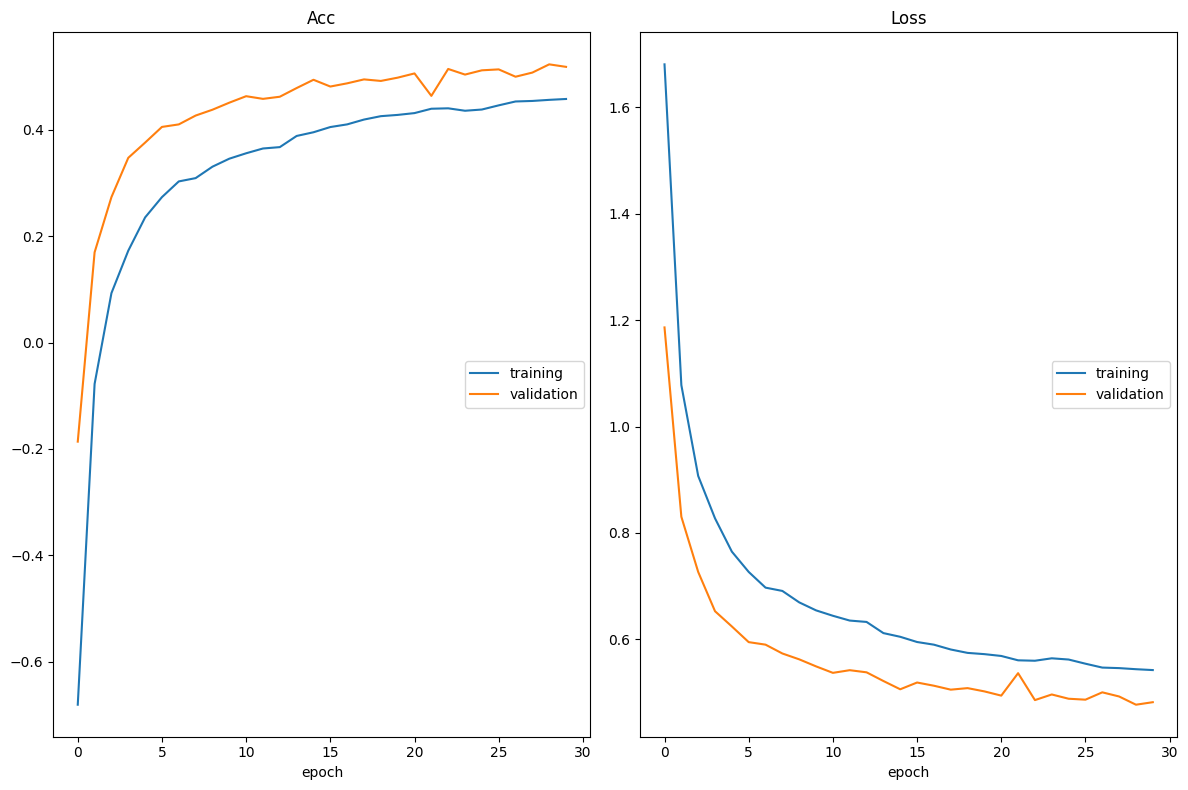

Acc
	training         	 (min:   -0.680, max:    0.458, cur:    0.458)
	validation       	 (min:   -0.186, max:    0.523, cur:    0.518)
Loss
	training         	 (min:    0.542, max:    1.680, cur:    0.542)
	validation       	 (min:    0.477, max:    1.186, cur:    0.482)


aug,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epochs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epochs_trained,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
init_lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
save_after_n_epochs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
save_best_model,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
save_weights_only,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▅▆▆▇▇▇▇▇▇▇▇▇█████████████████
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▆▆▇▇▇▇▇▇▇▇▇████████▇████████


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


CPU times: user 1h 22min 12s, sys: 12min 43s, total: 1h 34min 55s
Wall time: 3h 30min 5s


In [ ]:
%%time
#main script

#set the random seed
#random.seed(42)

if __name__ == '__main__':

  #read the pickle file
  df = pd.read_pickle(sweep_config['parameters']['data_path']['value'])

  #specify the sweep save location
  sweep_config['name'] = datetime.now().strftime('2d-unet-test-%Y-%m-%d-%H-%M-%S')
  #set
  sweep_config['parameters']['save_folder']['value'] = sweep_config['parameters']['save_folder']['value'] + sweep_config['name'] + '/'
  #create the sweep folder
  if os.path.isdir(sweep_config['parameters']['save_folder']['value']) == False:
    os.mkdir(sweep_config['parameters']['save_folder']['value'])
  #save the sweep config in the sweep folder
  save_params(sweep_config, sweep_config['parameters']['save_folder']['value'] + 'sweep_config.json')
  #now run the main script

  #select the project folder
  sweep_id = wandb.sweep(sweep_config, project = sweep_config['parameters']['project']['value'])
  #execute the search
  wandb.agent(sweep_id, main)
  #finish
  wandb.finish()

**Introduction**
1. The script is essentially a repeat of the previous training section, however, it treats the test set as the validation set (when plotting curves) and the model is trained on the whole dataset.
2. The output of this code falls in the Part1/results/folder where within the test folder, one can find the the model-specific folder with .pkl file listing the exact dataset split by fold, .pth file with model weights, and .json file with the precise hyper-parameters used.

**Justification**

1. The same attention to detail and reproducibility is put at the forefont by storing model parameters locally and online
2. The hyper-parameters need to be updated based upon the results of the optimization exercise.
3. In retrospect, rather than training on the entire dataset, the script could also just take a pretrained model and retrain it on the missing fold to save time.

**Conclusion**

1. The best performing model as informed by the hyper-parameter optimization activity is trained on the entire training dataset.

# Testing

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#installations
!pip install --quiet SimpleITK
!pip install --quiet segmentation-models-pytorch

In [ ]:
#imports
import glob
import json
import SimpleITK as sitk
import torch
import numpy as np
import pandas as pd
import glob
import segmentation_models_pytorch as smp
import os
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

#check if the gpu machine is available
if torch.cuda.is_available():
  device = 'cuda'
  gpu = torch.cuda.get_device_name(0)
  print('Device: ', gpu)
else:
  device = 'cpu'
  gpu = None
  print('Device', device)

Device:  Tesla T4


In [ ]:
#functions

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#split
def split_given_size(a, size):
  return np.split(a, np.arange(size, len(a), size))

#save image
def save_image(save_path, save_folder, patient, image):
  #save file
  if os.path.isdir(save_path + save_folder) == False:
    os.mkdir(save_path + save_folder)
  #save file
  save_loc = save_path + save_folder + '/' + patient + '.nii.gz'
  #write
  sitk.WriteImage(image, save_loc)
  #return
  return save_loc

#get the model
def get_model(model_config):
  #get the model for smp unet
  if model_config['architecture']['description'] == 'smp_unet':
    #https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/base/model.py
    model = smp.Unet(encoder_name = model_config['architecture']['encoder_name'],
                     encoder_depth = model_config['architecture']['encoder_depth'],
                     encoder_weights = model_config['architecture']['encoder_weights'] ,
                     decoder_use_batchnorm = model_config['architecture']['decoder_use_batchnorm'],
                     decoder_channels = model_config['architecture']['decoder_channels'],
                     decoder_attention_type = model_config['architecture']['decoder_attention_type'],
                     in_channels = model_config['architecture']['in_channels'],
                     classes = model_config['architecture']['classes'],
                     activation = model_config['architecture']['activation'],
                     aux_params = None)
    return model

#load pretrained model
def load_pretrained_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_model(model_config)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config

#Dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, col_image, input_size):
      #params
      self.df = df
      self.col_image = col_image
      self.input_size = input_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      #row
      row = self.df.iloc[idx]
      #read image
      image = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(sitk.ReadImage(row[self.col_image])), axis = 0))

      #init
      mask = torch.ones((1, self.input_size[0], self.input_size[1]))
      #random x
      x = random.randint(0, self.input_size[0]/2)
      #get random y
      y = random.randint(0, self.input_size[1]/2)
      #get random delta x
      xd = random.randint(self.input_size[0]/4, self.input_size[0]/2)
      #get random delta y
      yd = random.randint(self.input_size[1]/4, self.input_size[1]/2)
      #set the mask
      mask[:, x:x+xd, y:y+yd] = 0
      #apply
      cut_image = image * mask

      #return x_input
      return cut_image

#check if the file was written (issue with Colab it seems)
def check_file(row):
  #check if the path exists
  if os.path.exists(row['Prediction']) == False:
    return False
  else:
    return True

In [ ]:
#init for sliding window patient inference

#specify the sweep folder
sweep_path = '/content/gdrive/MyDrive/DL_Assignment/Part1/results/2d-unet-test-2023-06-12-18-18-59/'
#specify the model tag
model_tag = '2d-unet-painting'

In [ ]:
%%time

#first pass over

#init
model = None
#reset
if device == 'cuda':
  torch.cuda.empty_cache()

#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#iterate
for sweep_folder in sweep_folders:
  #load in the params
  model, model_config = load_pretrained_model(sweep_folder + '/', device)
  #load in the results file
  df = pd.read_pickle(model_config['save_folder'] + 'df_results.pkl')
  #need to obtain the data
  ls_df = split_given_size(df, model_config['batch_size']) #num patients in batch (estimate)
  #prep
  model.to(device)
  #eval
  model.eval()
  #init
  ls_results = []
  #load the data
  dset_infer = CustomImageDataset(df, model_config['col_image'], model_config['input_size'])
  #load
  infer_loader = DataLoader(dset_infer, batch_size = model_config['batch_size'])
  #infer
  for i, x_input in enumerate(infer_loader):
    #get the small df
    df_small = ls_df[i]
    #less compute
    with torch.no_grad():
      #forward pass
      x_pred = model(x_input.to(device))
      #detach
      batch_prediction = np.squeeze(x_pred.detach().cpu().numpy())
      #clear
      x_pred = None
      #reset
      if device == 'cuda':
        torch.cuda.empty_cache()
    #iterate
    for j in range(len(df_small)):
      #row
      row = df_small.iloc[j]
      #batch
      patient_prediction = sitk.GetImageFromArray(batch_prediction[j, ])
      #save image
      save_path = save_image(model_config['save_folder'], 'predictions', str(row['ID']), patient_prediction)
      #append
      ls_results.append(save_path)
    #print
    print('Finished Batch: {0} of {1}'.format (i+1, len(ls_df)))
  #save the results
  df['Prediction'] = ls_results
  #save
  df.to_pickle(model_config['save_folder'] + 'df_results.pkl')
  #clear
  model = None
  #reset
  if device == 'cuda':
    torch.cuda.empty_cache()

Finished Batch: 1 of 75
Finished Batch: 2 of 75
Finished Batch: 3 of 75
Finished Batch: 4 of 75
Finished Batch: 5 of 75
Finished Batch: 6 of 75
Finished Batch: 7 of 75
Finished Batch: 8 of 75
Finished Batch: 9 of 75
Finished Batch: 10 of 75
Finished Batch: 11 of 75
Finished Batch: 12 of 75
Finished Batch: 13 of 75
Finished Batch: 14 of 75
Finished Batch: 15 of 75
Finished Batch: 16 of 75
Finished Batch: 17 of 75
Finished Batch: 18 of 75
Finished Batch: 19 of 75
Finished Batch: 20 of 75
Finished Batch: 21 of 75
Finished Batch: 22 of 75
Finished Batch: 23 of 75
Finished Batch: 24 of 75
Finished Batch: 25 of 75
Finished Batch: 26 of 75
Finished Batch: 27 of 75
Finished Batch: 28 of 75
Finished Batch: 29 of 75
Finished Batch: 30 of 75
Finished Batch: 31 of 75
Finished Batch: 32 of 75
Finished Batch: 33 of 75
Finished Batch: 34 of 75
Finished Batch: 35 of 75
Finished Batch: 36 of 75
Finished Batch: 37 of 75
Finished Batch: 38 of 75
Finished Batch: 39 of 75
Finished Batch: 40 of 75
Finished 

**Introduction**
1. By pointing to a specific sweep folder, one can run model inference.
2. A seperate subfolder will be created under the model-specific folder storing the model predictions and df_results.pkl will be updated with the relevant filepaths.

**Justification**

1. The script is designed to take advantage of the model's ability to batch predictions, however, Colab is primarily confined to the speed of reading/writing files so it still requires a significant amount of time to run.
2. The removed image patches are taken at random, under the belief that when looing at performance across groups, individual patient variations will be minimized.
3. In retrospect, having the script indicate how may patients it has finished seems essential for preventing a stale environment.

**Conclusion**

1. One can obtain model predictions in an organized format.

# Evaluation

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#installations
!pip install --quiet SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 15.2 MB/s eta 0:00:00


In [ ]:
#imports
import glob
import json
import SimpleITK as sitk
import torch
import numpy as np
import pandas as pd
import glob
import os
import skimage
import matplotlib.pyplot as plt

In [ ]:
#get performance
def get_performance(row):
  #read in the sitk image
  pred = sitk.GetArrayFromImage(sitk.ReadImage(row['Prediction']))
  gt = sitk.GetArrayFromImage(sitk.ReadImage(row['Norm-Rad']))
  #obtain results
  mse = skimage.metrics.mean_squared_error(gt, pred)
  psnr = skimage.metrics.peak_signal_noise_ratio(gt, pred)
  ssim = skimage.metrics.structural_similarity(gt, pred)
  #return
  return mse, psnr, ssim

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#save performance metrics
def get_metrics(df, model_config):
  #dataset
  dataset = ['TRAIN', 'TEST']
  #metrics
  metrics = ['MSE', 'PSNR', 'SSIM']
  #type
  data_types = ['mean', 'std']
  #init
  results = {}
  #iterate
  for data in dataset:
    for metric in metrics:
      for data_type in data_types:
        results[data_type + '_' + data + '_' + metric] = df[df['Split'] == data][metric].describe()[data_type]
  #insert
  model_config['results'] = results
  #return
  return model_config

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#check if the file was written (issue with Colab it seems)
def check_file(row):
  #check if the path exists
  if os.path.exists(row['Prediction']) == False:
    print('Issue: ', row['ID'])
    return False
  else:
    return True

#split given size
def split_given_size(a, size):
  return np.split(a, np.arange(size, len(a), size))

#plot some examples
def plotter(row):
  #row
  gt = sitk.GetArrayFromImage(sitk.ReadImage(row['Rad']))
  p = sitk.GetArrayFromImage(sitk.ReadImage(row['Prediction']))
  plt.figure(figsize = (10, 10))
  plt.subplot(1, 2, 1)
  plt.imshow(gt, cmap = 'gray')
  plt.title('Original')
  plt.subplot(1, 2, 2)
  plt.imshow(p, cmap = 'gray')
  plt.title('Painted (Predicted)')
  plt.show()
  print('MSE {0:.2g} & SSIM {1:.2g} & PSNR {2:.4g}'.format(row['MSE'], row['SSIM'], row['PSNR']))

In [ ]:
#specify the sweep folder
sweep_path = '/content/gdrive/MyDrive/DL_Assignment/Part1/results/2d-unet-test-2023-06-12-18-18-59/'
#specify the model tag
model_tag = '2d-unet-painting'

In [ ]:
%%time

#collect performance metrics

#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#iterate
for sweep_folder in sweep_folders:
  #read in the model_config file
  model_config = load_params(sweep_folder + '/' + 'model_config.json')
  #read in the df file
  df = pd.read_pickle(model_config['save_folder'] + 'df_results.pkl')
  #check
  df['Written'] = df.apply(check_file, axis = 1)
  #split
  ls_df = split_given_size(df, model_config['batch_size']) #num patients in batch (estimate)
  #ls
  df_metrics = []
  #iterate
  for i, df_small in enumerate(ls_df):
    #get the performance metrics
    df_small['MSE'], df_small['PSNR'], df_small['SSIM'] = zip(*df_small.apply(get_performance, axis = 1))
    #append
    df_metrics.append(df_small)
    #print
    print('Finished Batch: {0} of {1}'.format (i+1, len(ls_df)))
  #concat
  df_results = pd.concat(df_metrics)
  #save the results when complete
  df_results.to_pickle(model_config['save_folder'] + 'df_results.pkl')

Finished Batch: 1 of 75
Finished Batch: 2 of 75
Finished Batch: 3 of 75
Finished Batch: 4 of 75
Finished Batch: 5 of 75
Finished Batch: 6 of 75
Finished Batch: 7 of 75
Finished Batch: 8 of 75
Finished Batch: 9 of 75
Finished Batch: 10 of 75
Finished Batch: 11 of 75
Finished Batch: 12 of 75
Finished Batch: 13 of 75
Finished Batch: 14 of 75
Finished Batch: 15 of 75
Finished Batch: 16 of 75
Finished Batch: 17 of 75
Finished Batch: 18 of 75
Finished Batch: 19 of 75
Finished Batch: 20 of 75
Finished Batch: 21 of 75
Finished Batch: 22 of 75
Finished Batch: 23 of 75
Finished Batch: 24 of 75
Finished Batch: 25 of 75
Finished Batch: 26 of 75
Finished Batch: 27 of 75
Finished Batch: 28 of 75
Finished Batch: 29 of 75
Finished Batch: 30 of 75
Finished Batch: 31 of 75
Finished Batch: 32 of 75
Finished Batch: 33 of 75
Finished Batch: 34 of 75
Finished Batch: 35 of 75
Finished Batch: 36 of 75
Finished Batch: 37 of 75
Finished Batch: 38 of 75
Finished Batch: 39 of 75
Finished Batch: 40 of 75
Finished 

In [ ]:
%%time

#analyze performance metrics https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf

#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#iterate
for sweep_folder in sweep_folders:
  #read in the model_config file
  model_config = load_params(sweep_folder + '/' + 'model_config.json')
  #read in the df file
  df = pd.read_pickle(model_config['save_folder'] + 'df_results.pkl')
  #get the performance metrics
  model_config = get_metrics(df, model_config)
  #save
  save_params(model_config, model_config['save_folder'] + 'model_config.json')

CPU times: user 91.1 ms, sys: 8.54 ms, total: 99.6 ms
Wall time: 282 ms


In [ ]:
#rank
rank = 'mean_TEST_SSIM'
#cols
cols = [
    'mean_TRAIN_MSE',
    'mean_TRAIN_SSIM',
    'mean_TRAIN_PSNR',
    'mean_TEST_MSE',
    'mean_TEST_SSIM',
    'mean_TEST_PSNR',
    'save_folder'
]
#plot
num_samples = 4

In [ ]:
%%time

#view performance metrics
ls_metrics = []
#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#iterate
for sweep_folder in sweep_folders:
  #read in the model_config file
  model_config = load_params(sweep_folder + '/' + 'model_config.json')
  #get
  data_config = model_config['results']
  data_config['save_folder'] = model_config['save_folder']
  #append
  ls_metrics.append(data_config)

#convert
df_opt = pd.DataFrame(ls_metrics)
#rank
df_opt = df_opt.sort_values(by = [rank], ascending = False)
#display
display(df_opt[cols].round(4))
#save
df_opt.to_pickle(sweep_path + 'df_opt.pkl')
#show the model config
row = df_opt.iloc[0]
#read
model_config = load_params(row['save_folder'] + 'model_config.json')
#show params used for retraining on entre validation set
#print(model_config)

,mean_TRAIN_MSE,mean_TRAIN_SSIM,mean_TRAIN_PSNR,mean_TEST_MSE,mean_TEST_SSIM,mean_TEST_PSNR,save_folder
0,0.0016,0.9517,29.0067,0.0016,0.9511,28.9712,/content/gdrive/MyDrive/DL_Assignment/Part1/re...


CPU times: user 29.9 ms, sys: 1.47 ms, total: 31.4 ms
Wall time: 137 ms


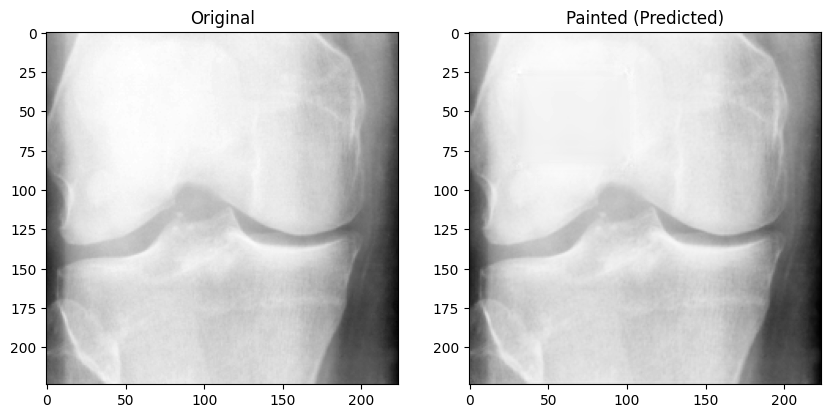

MSE 0.00062 & SSIM 1 & PSNR 32.09


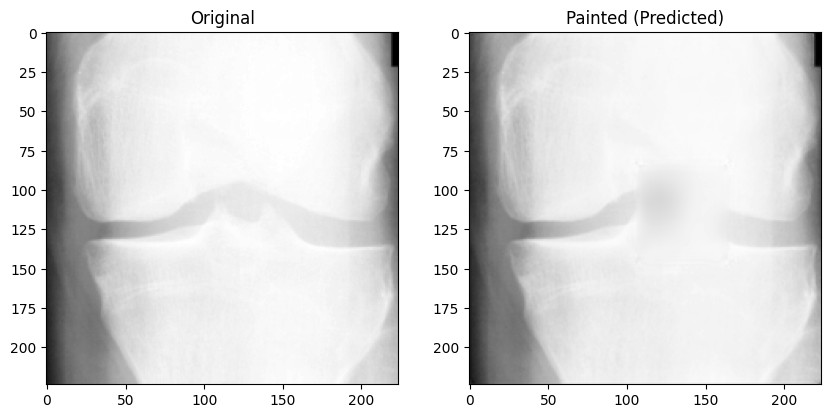

MSE 0.0011 & SSIM 0.99 & PSNR 29.73


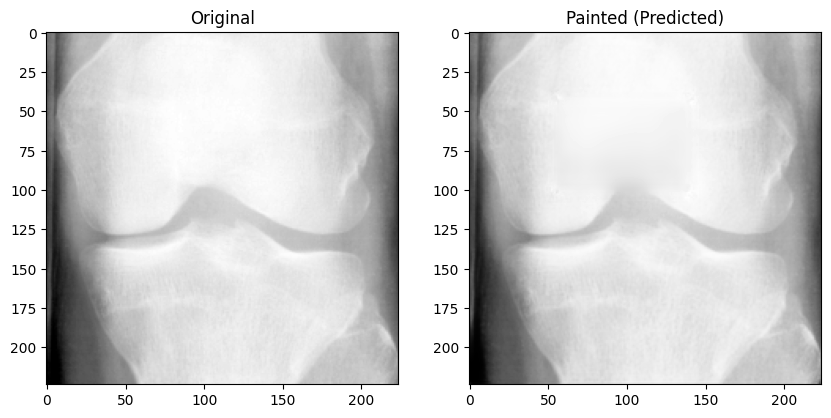

MSE 0.00077 & SSIM 0.99 & PSNR 31.16


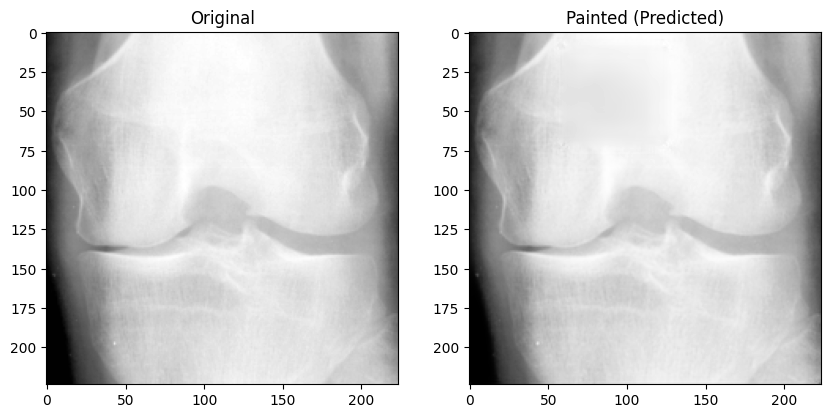

MSE 0.00088 & SSIM 0.99 & PSNR 30.56


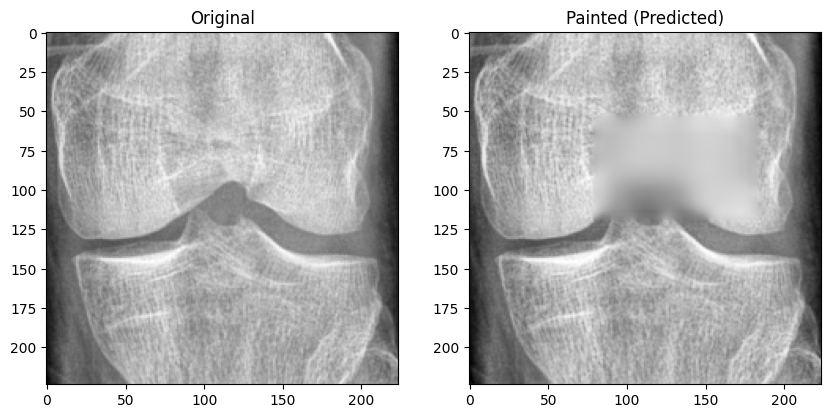

MSE 0.00063 & SSIM 0.95 & PSNR 32.02


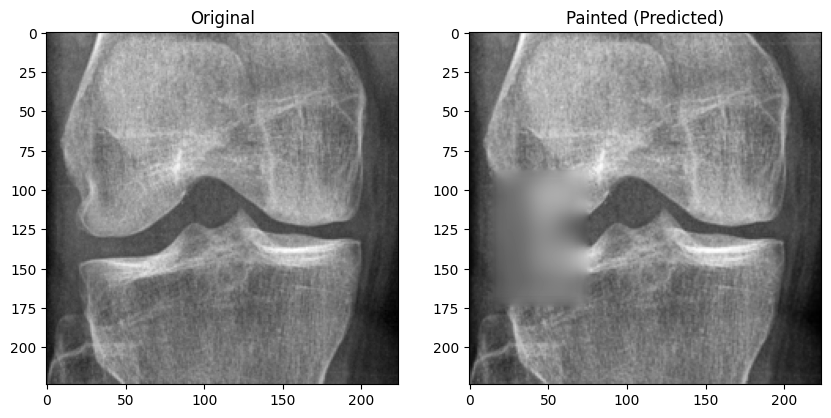

MSE 0.0015 & SSIM 0.95 & PSNR 28.3


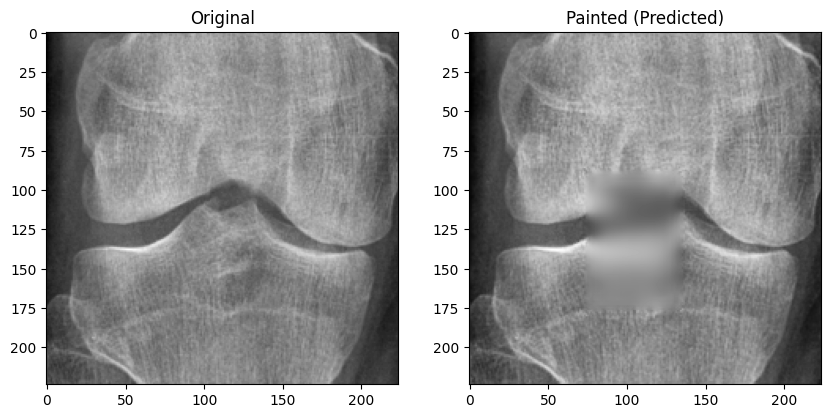

MSE 0.001 & SSIM 0.95 & PSNR 29.86


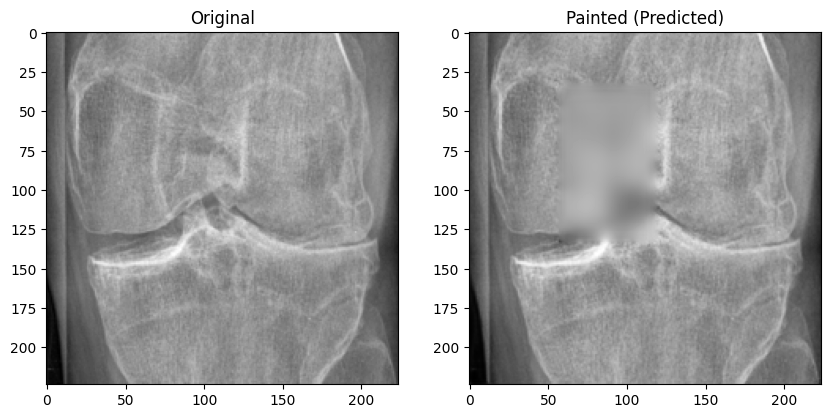

MSE 0.0007 & SSIM 0.95 & PSNR 31.56


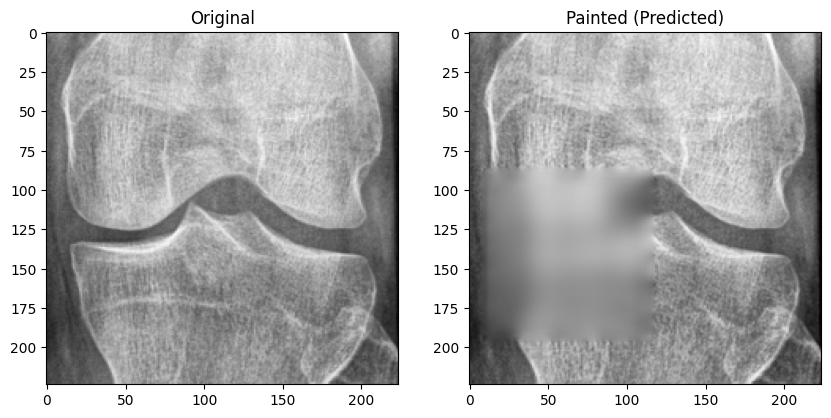

MSE 0.0027 & SSIM 0.89 & PSNR 25.69


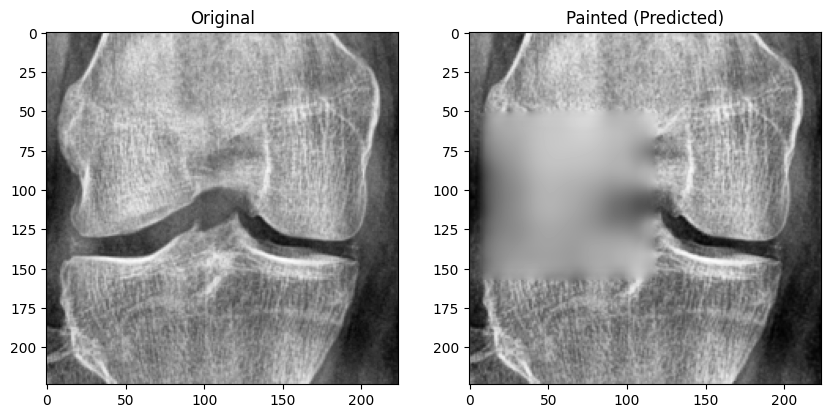

MSE 0.0042 & SSIM 0.88 & PSNR 23.78


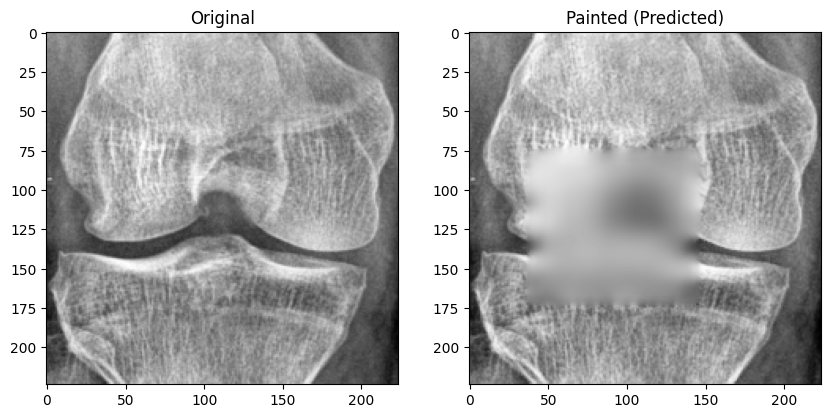

MSE 0.0049 & SSIM 0.87 & PSNR 23.09


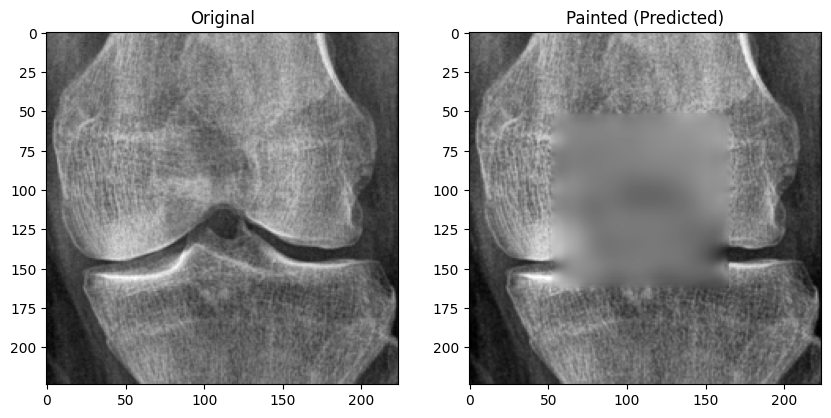

MSE 0.0041 & SSIM 0.86 & PSNR 23.88
CPU times: user 8.9 s, sys: 686 ms, total: 9.59 s
Wall time: 21.4 s


In [ ]:
%%time
#read
df = pd.read_pickle(model_config['save_folder'] + 'df_results.pkl')
#test set
df = df[df['Split'] == 'TEST']
#rank
df = df.sort_values(['SSIM'], ascending = False)
#get average
df_mid = df.iloc[int((len(df)/2) - int(num_samples/2)):int((len(df)/2) + int(num_samples/2))]
#concat
df_dist = pd.concat([df.head(num_samples), df_mid, df.tail(num_samples)])
#now plot
_ = df_dist.apply(plotter, axis = 1)

**Introduction**
1. The first section is responsible for obtaining the performance metrics (MSE, SSIM, PSNR) and storing patient-specific results in the model specific df_results.pkl file. Since it requires reading files, it takes a significnt amount of time to run.
2. The second section is responsible for storing the specific dataset (training, testing) results in the model_config.json file.
3. The third section is responsible for displaying the model based upon the chosen [test SSIM] and other dataset specific metrics.
4. The fourth section provides some test set examples (best, average, and worst predictions).

**Justification**

1. The above table allows users to visualize the final model's performance metrics.
2. MSE: mean squared error (quantity to be minimized)
2. SSIM: structural similarity index (quantity to be maximized)
3. PSNR: peak signal-to-noise ratio (quantity to be maximized)

**Conclusion**

1. The optimal model is identified by it's performance.

# Other

This section contains some scrapped code.

In [ ]:
%%time

#functions

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#obtain masks
def get_masks(input_size = (224, 224)):
  #init
  mask = torch.ones((16, 1, input_size[0], input_size[1]))
  xd = int(inpu
  count = 0
  #iterate
  for i in range(4):
    for j in range(4):
      #set x and y
      x = i * xd
      y = j * yd
      #update mask
      mask[count, :, x:x+xd, y:y+yd] = 0
      count = count + 1
  #return
  return mask

#patient predictions
def patient_inputs(row, mask, windows = 16):
  #read in the data
  rad = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(sitk.ReadImage(row['Norm-Rad'])), axis = (0, 1)))
  #sliding window
  batch_rad = torch.repeat_interleave(rad, windows, 0)
  #multiply
  inputs = batch_rad * mask
  #return
  return inputs

#split
def split_given_size(a, size):
  return np.split(a, np.arange(size, len(a), size))

#save image
def save_image(save_path, save_folder, patient, image):
  #save file
  if os.path.isdir(save_path + save_folder) == False:
    os.mkdir(save_path + save_folder)
  #save file
  save_loc = save_path + save_folder + '/' + patient + '.nii.gz'
  #write
  sitk.WriteImage(image, save_loc)
  #return
  return save_loc

#get the model
def get_model(model_config):
  #get the model for smp unet
  if model_config['architecture']['description'] == 'smp_unet':
    #https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/base/model.py
    model = smp.Unet(encoder_name = model_config['architecture']['encoder_name'],
                     encoder_depth = model_config['architecture']['encoder_depth'],
                     encoder_weights = model_config['architecture']['encoder_weights'] ,
                     decoder_use_batchnorm = model_config['architecture']['decoder_use_batchnorm'],
                     decoder_channels = model_config['architecture']['decoder_channels'],
                     decoder_attention_type = model_config['architecture']['decoder_attention_type'],
                     in_channels = model_config['architecture']['in_channels'],
                     classes = model_config['architecture']['classes'],
                     activation = model_config['architecture']['activation'],
                     aux_params = None)
    return model

#load pretrained model
def load_pretrained_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_model(model_config)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config

#init
model = None
#reset
if device == 'cuda':
  torch.cuda.empty_cache()

#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#get masks
mask = get_masks()
#results
ls_results = []
#iterate
for sweep_folder in sweep_folders:
  #load in the params
  model, model_config = load_pretrained_model(sweep_folder + '/', device)
  #load in the results file
  df = pd.read_pickle(model_config['save_folder'] + 'df_results.pkl')
  #need to obtain the data
  ls_df = split_given_size(df, 7) #num patients
  #prep
  model.to(device)
  #eval
  model.eval()
  #iterate
  for df_small in ls_df:
    #get
    model_inputs = list(df_small.apply(patient_inputs, axis = 1, args = (mask, )))
    #concat
    batch_model_inputs = torch.concat(model_inputs, dim = 0)
    #less compute for backprop
    with torch.no_grad():
      #pass
      batch_predictions = model(batch_model_inputs.to(device))
      #detach
      model_predictions = np.squeeze(batch_predictions.detach().cpu().numpy())
    #split
    patient_predictions = split_given_size(model_predictions, 16) #num windows  per patient
    #iterate
    for i in range(len(df_small)): #num patients
      #row
      row = df_small.iloc[i]
      #single patient image
      sitk_pred = sitk.GetImageFromArray(patient_predictions[i])
      #save image
      save_path = save_image(model_config['save_folder'], 'predictions', str(row['ID']), sitk_pred)
      #append
      ls_results.append(save_path)
  #save the results
  df['Predictions'] = ls_results
  #save
  df.to_pickle(model_config['save_folder'] + 'df_results.pkl')
  #clear
  model = None
  #reset
  if device == 'cuda':
    torch.cuda.empty_cache()